# PS Injection Dispersion Mismatch

### Compare optics for SEM Grid BSGH52 measurement lattice and used MD211 lattice. 
- Note that MD211 refers to this simulation repository, PS_Transfer is another respository found: https://github.com/HaroonRafique/PS_Transfer in which the transfer line dispersion mismatch SEM grid measurements are understood using space charge simulations

### imports

In [39]:
import os
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from math import floor, log10

import matplotlib.cm as cm
#! pip install --user wand
#import wand
from wand.image import Image as WImage

### Function Definitions

In [18]:
def round_sig(x, sig=3):
    return round(x, sig-int(floor(log10(abs(x))))-1)

In [19]:
def make_directory(path):
    try:
        os.mkdir(path)
    except OSError:
        print ("Creation of the directory %s failed" % path)
    else:
        print ("Successfully created the directory %s " % path)  

In [20]:
########################################################################
# Read PTC Twiss and return dictionary of columns/values
########################################################################
def Read_PTC_Twiss_Return_Dict(filename, verbose=True):
    # Dictionary for output
    d = dict()
    d['HEADER_FILENAME'] = [filename]
    keywords = ''
    
    # First we open and count header lines
    fin0=open(filename,'r').readlines()
    headerlines = 0
    for l in fin0:
        # Store each header line
        headerlines = headerlines + 1
        # Stop if we find the line starting '* NAME'
        if '* NAME' in l:
            keywords = l
            break
        # Store the headers as d['HEADER_<name>'] = <value>
        else:
            #try:
            #    d[str('HEADER_'+l.split()[1])]=[float(l.split()[-1])]     
            #except ValueError:
            #    d[str('HEADER_'+l.split()[1])]=[str(l.split()[-1])]   
            if '"' in l:
                d[str('HEADER_'+l.split()[1])]=[str(l.split('"')[1])]
            else:
                d[str('HEADER_'+l.split()[1])]=[float(l.split()[-1])]                 
    headerlines = headerlines + 1    
    
    if verbose: print '\nRead_PTC_Twiss_Return_Dict found Keywords: \n',keywords
    
    # Make a list of column keywords to return (as an aid to iterating)
    dict_keys = []
    for key in keywords.split():
        dict_keys.append(key)
    dict_keys.remove('*')
    
    if verbose: print '\nRead_PTC_Twiss_Return_Dict Dict Keys: \n',dict_keys
    
    # Initialise empty dictionary entries for column keywords 
    for key in dict_keys:
        d[key]=[]
        
    if verbose: 
        print '\nRead_PTC_Twiss_Return_Dict header only dictionary \n'
        for i in d:
            print i, d[i]
    
    # Strip header
    fin1=open(filename,'r').readlines()[headerlines:]   
    
    # Populate the dictionary line by line
    for l in fin1:
        i = -1        
        for value in l.split():
            i = i+1
            if 'NAME' in dict_keys[i]:
                d[dict_keys[i]].append(str(value))
            else:
                d[dict_keys[i]].append(float(value))    
                
    # Return list of column keywords 'dict_keys', and dictionary 'd'
    return dict_keys, d

In [21]:
# Function to print lines between min_ and max_ values
def print_some_lines(line_list, min_, max_):
    j = 0
    for i in madx_simulation_lines:
        if (j <= max_) and (j >= min_):
            print i
        j = j + 1
    return

print_all_lines = lambda x: sys.stdout.write("\n".join(x) + "\n")


In [107]:
def return_initial_Parameter(d, parameter, sig_limit=3):
    return d[parameter][0] 

def print_Twiss_Dict_Parameter(d, parameter, sig_limit=3):
    print parameter, ' = ', round_sig(d[parameter][0],sig_limit) 

def print_Twiss_Dict_Tunes(d, sig_limit=3):
    print '(Qx, Qy) = (', round_sig(d['HEADER_Q1'][0],sig_limit) , ',' , round_sig(d['HEADER_Q2'][0],sig_limit) , ')'
    

In [23]:
def LorentzBeta(gamma):
    return np.sqrt( 1. - (1./gamma**2) )

In [128]:
# M_D is the mismatch factor as identified by measurements
def find_dispersion_mismatch(d, Horizontal=True, M_D=0.35, beta = 0.9156, verbose=True):
    
    D_0 = return_initial_Parameter(d, 'DISP1')*beta
    if Horizontal:
        Beta_0 = return_initial_Parameter(d, 'BETX')
        
    else:
        Beta_0 = return_initial_Parameter(d, 'BETY')
        
    D_0_norm = D_0 / np.sqrt(Beta_0)
    
    D_m_norm = D_0_norm + M_D
    
    D_m = D_m_norm * np.sqrt(Beta_0)
    
    Delta_D = D_m - D_0
    
    if verbose:
        print_Twiss_Dict_Tunes(d,2)
        print '\tD_0 = ', round_sig(D_0,5)
        print '\tD_0_norm = ', round_sig(D_0_norm,5)
        print '\tD_mismatched_norm = ', round_sig(D_m_norm,5)
        print '\tD_mismatched = ', round_sig(D_m,5)
        print '\tDelta_D_mismatched = ', round_sig(Delta_D,5)
    
    return Delta_D, D_m
    

### Plot Parameters

In [24]:
plt.rcParams['figure.figsize'] = [8.0, 5.0]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200

plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 14

plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

plt.rcParams['font.size'] = 10
plt.rcParams['legend.fontsize'] = 8

plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 5

In [25]:
save_folder = 'Plots/'
make_directory(save_folder)
legend_label = 'Case'
main_label = 'MD4224_Dispersion_Mismatch'

Creation of the directory Plots/ failed


# Step 1: Load all PTC Twiss

In [26]:
PTC_gamma = 2.49038064
beta = LorentzBeta(PTC_gamma)

In [27]:
beta

0.9158392756488949

In [28]:
LEQ_H_07_keys, LEQ_H_07 = Read_PTC_Twiss_Return_Dict('PTC_Twiss/H_07.tfs')
LEQ_H_08_keys, LEQ_H_08 = Read_PTC_Twiss_Return_Dict('PTC_Twiss/H_08.tfs')
LEQ_H_09_keys, LEQ_H_09 = Read_PTC_Twiss_Return_Dict('PTC_Twiss/H_09.tfs')
LEQ_H_10_keys, LEQ_H_10 = Read_PTC_Twiss_Return_Dict('PTC_Twiss/H_10.tfs')
LEQ_H_11_keys, LEQ_H_11 = Read_PTC_Twiss_Return_Dict('PTC_Twiss/H_11.tfs')
LEQ_H_12_keys, LEQ_H_12 = Read_PTC_Twiss_Return_Dict('PTC_Twiss/H_12.tfs')
LEQ_H_13_keys, LEQ_H_13 = Read_PTC_Twiss_Return_Dict('PTC_Twiss/H_13.tfs')
LEQ_H_14_keys, LEQ_H_14 = Read_PTC_Twiss_Return_Dict('PTC_Twiss/H_14.tfs')
LEQ_H_15_keys, LEQ_H_15 = Read_PTC_Twiss_Return_Dict('PTC_Twiss/H_15.tfs')
LEQ_H_16_keys, LEQ_H_16 = Read_PTC_Twiss_Return_Dict('PTC_Twiss/H_16.tfs')
LEQ_H_17_keys, LEQ_H_17 = Read_PTC_Twiss_Return_Dict('PTC_Twiss/H_17.tfs')
LEQ_H_18_keys, LEQ_H_18 = Read_PTC_Twiss_Return_Dict('PTC_Twiss/H_18.tfs')
LEQ_H_19_keys, LEQ_H_19 = Read_PTC_Twiss_Return_Dict('PTC_Twiss/H_19.tfs')
LEQ_H_20_keys, LEQ_H_20 = Read_PTC_Twiss_Return_Dict('PTC_Twiss/H_20.tfs')
LEQ_H_21_keys, LEQ_H_21 = Read_PTC_Twiss_Return_Dict('PTC_Twiss/H_21.tfs')
LEQ_H_List = [LEQ_H_07, LEQ_H_08, LEQ_H_09, LEQ_H_10, LEQ_H_11, LEQ_H_12, LEQ_H_13, LEQ_H_14, LEQ_H_15, LEQ_H_16, LEQ_H_17, LEQ_H_18, LEQ_H_19, LEQ_H_20, LEQ_H_21]


Read_PTC_Twiss_Return_Dict found Keywords: 
* NAME                                S               BETX               BETY               ALFX               ALFY              DISP1              DISP2              DISP3              DISP4                MU1                MU2                  X                 PX                  Y                 PY 


Read_PTC_Twiss_Return_Dict Dict Keys: 
['NAME', 'S', 'BETX', 'BETY', 'ALFX', 'ALFY', 'DISP1', 'DISP2', 'DISP3', 'DISP4', 'MU1', 'MU2', 'X', 'PX', 'Y', 'PY']

Read_PTC_Twiss_Return_Dict header only dictionary 

HEADER_ETA_C [-0.1329643408]
HEADER_TCOMIN [0.0]
HEADER_BETA11MIN [10.01946085]
HEADER_DELTAP [0.0]
HEADER_BETA33MIN [0.0]
HEADER_TCOMAX [0.0]
HEADER_PC [2.14]
HEADER_BETA22MAX [24.15254239]
HEADER_BETA12MIN [0.0]
HEADER_ALPHA_C [0.02827408041]
HEADER_BETA_X_MAX [29.23376144]
HEADER_BETA_X_MIN [10.01946085]
HEADER_ALPHA_C_P2 [-1000000.0]
HEADER_ALPHA_C_P3 [-1000000.0]
HEADER_BETA13MIN [0.0]
HEADER_TITLE ['Flat file generation for PT

ALFX []
HEADER_BETA23MAX [0.0]
MU1 []
NAME []
MU2 []
HEADER_TYPE ['TWISS']
HEADER_FILENAME ['PTC_Twiss/H_13.tfs']
HEADER_YCOMAX [0.0]
HEADER_XCOMAX [0.0]
HEADER_TIME ['09.41.18']
HEADER_SIGT [0.0]
HEADER_DISP3MIN [0.0]
HEADER_ORBIT_-CT [0.0]
HEADER_DQ2 [-7.771894432]
HEADER_DQ1 [-5.668921489]
HEADER_PYCOMIN [0.0]
HEADER_SIGE [0.0]
HEADER_NPART [0.0]
HEADER_LENGTH [628.3185]
HEADER_NAME ['PTC_TWISS']
HEADER_PYCOMAX [0.0]
DISP1 []
DISP3 []
DISP2 []
DISP4 []
HEADER_ORIGIN ['MAD-X 5.02.00 Linux 64']
Y []
HEADER_PXCOMAX [0.0]
HEADER_CHARGE [1.0]
HEADER_DISP4MAX [0.0]
HEADER_DISP4MIN [0.0]

Read_PTC_Twiss_Return_Dict found Keywords: 
* NAME                                S               BETX               BETY               ALFX               ALFY              DISP1              DISP2              DISP3              DISP4                MU1                MU2                  X                 PX                  Y                 PY 


Read_PTC_Twiss_Return_Dict Dict Keys: 
['NAME', 'S', 'B

HEADER_BETA13MAX [0.0]
HEADER_BETA11MAX [23.67333437]
HEADER_ALPHA_C_P [-0.5923777131]
HEADER_PXCOMIN [0.0]
HEADER_PYCORMS [0.0]
X []
HEADER_PARTICLE ['PROTON']
HEADER_KBUNCH [1.0]
HEADER_PTCORMS [0.0]
HEADER_GAMMA_TR [6.073998086]
HEADER_ORBIT_PT [0.0]
HEADER_BETA33MAX [0.0]
HEADER_BETA12MAX [0.0]
HEADER_ORBIT_PX [0.0]
HEADER_ORBIT_PY [0.0]
HEADER_PTCOMAX [0.0]
HEADER_BETA32MIN [0.0]
HEADER_BETA31MAX [0.0]
HEADER_TCORMS [0.0]
HEADER_BETA32MAX [0.0]
HEADER_DISP2MAX [0.3964296849]
HEADER_XCORMS [0.0]
HEADER_DATE ['17/08/20']
HEADER_DISP2MIN [-0.3971803158]
HEADER_BCURRENT [0.0]
HEADER_Q1 [0.1995106684]
HEADER_Q2 [0.240122004]
HEADER_BETA22MIN [11.50693875]
PX []
PY []
HEADER_PTCOMIN [0.0]
HEADER_GAMMA [2.49038064]
HEADER_DISP3MAX [0.0]
HEADER_QS [0.0]
S []
HEADER_BETA21MIN [0.0]
HEADER_BETA_Y_MAX [23.26805337]
HEADER_ENERGY [2.336654539]
HEADER_BETA31MIN [0.0]
HEADER_SEQUENCE ['PS']
HEADER_PXCORMS [0.0]
HEADER_BETA_Y_MIN [11.50693875]
HEADER_MASS [0.938272046]
HEADER_DISP1MIN [0.0]
HEAD

In [29]:
for d in LEQ_H_List:
    print_Twiss_Dict_Tunes(d,2)

(Qx, Qy) = ( 0.07 , 0.24 )
(Qx, Qy) = ( 0.08 , 0.24 )
(Qx, Qy) = ( 0.09 , 0.24 )
(Qx, Qy) = ( 0.1 , 0.24 )
(Qx, Qy) = ( 0.11 , 0.24 )
(Qx, Qy) = ( 0.12 , 0.24 )
(Qx, Qy) = ( 0.13 , 0.24 )
(Qx, Qy) = ( 0.14 , 0.24 )
(Qx, Qy) = ( 0.15 , 0.24 )
(Qx, Qy) = ( 0.16 , 0.24 )
(Qx, Qy) = ( 0.17 , 0.24 )
(Qx, Qy) = ( 0.18 , 0.24 )
(Qx, Qy) = ( 0.19 , 0.24 )
(Qx, Qy) = ( 0.2 , 0.24 )
(Qx, Qy) = ( 0.21 , 0.24 )


In [30]:
LEQ_V_10_keys, LEQ_V_10 = Read_PTC_Twiss_Return_Dict('PTC_Twiss/V_10.tfs')
LEQ_V_11_keys, LEQ_V_11 = Read_PTC_Twiss_Return_Dict('PTC_Twiss/V_11.tfs')
LEQ_V_12_keys, LEQ_V_12 = Read_PTC_Twiss_Return_Dict('PTC_Twiss/V_12.tfs')
LEQ_V_13_keys, LEQ_V_13 = Read_PTC_Twiss_Return_Dict('PTC_Twiss/V_13.tfs')
LEQ_V_14_keys, LEQ_V_14 = Read_PTC_Twiss_Return_Dict('PTC_Twiss/V_14.tfs')
LEQ_V_15_keys, LEQ_V_15 = Read_PTC_Twiss_Return_Dict('PTC_Twiss/V_15.tfs')
LEQ_V_16_keys, LEQ_V_16 = Read_PTC_Twiss_Return_Dict('PTC_Twiss/V_16.tfs')
LEQ_V_17_keys, LEQ_V_17 = Read_PTC_Twiss_Return_Dict('PTC_Twiss/V_17.tfs')
LEQ_V_18_keys, LEQ_V_18 = Read_PTC_Twiss_Return_Dict('PTC_Twiss/V_18.tfs')
LEQ_V_19_keys, LEQ_V_19 = Read_PTC_Twiss_Return_Dict('PTC_Twiss/V_19.tfs')
LEQ_V_20_keys, LEQ_V_20 = Read_PTC_Twiss_Return_Dict('PTC_Twiss/V_20.tfs')
LEQ_V_21_keys, LEQ_V_21 = Read_PTC_Twiss_Return_Dict('PTC_Twiss/V_21.tfs')
LEQ_V_22_keys, LEQ_V_22 = Read_PTC_Twiss_Return_Dict('PTC_Twiss/V_22.tfs')
LEQ_V_23_keys, LEQ_V_23 = Read_PTC_Twiss_Return_Dict('PTC_Twiss/V_23.tfs')
LEQ_V_24_keys, LEQ_V_24 = Read_PTC_Twiss_Return_Dict('PTC_Twiss/V_24.tfs')
LEQ_V_List = [LEQ_V_10, LEQ_V_11, LEQ_V_12, LEQ_V_13, LEQ_V_14, LEQ_V_15, LEQ_V_16, LEQ_V_17, LEQ_V_18, LEQ_V_19, LEQ_V_20, LEQ_V_21, LEQ_V_22, LEQ_V_23, LEQ_V_24]


Read_PTC_Twiss_Return_Dict found Keywords: 
* NAME                                S               BETX               BETY               ALFX               ALFY              DISP1              DISP2              DISP3              DISP4                MU1                MU2                  X                 PX                  Y                 PY 


Read_PTC_Twiss_Return_Dict Dict Keys: 
['NAME', 'S', 'BETX', 'BETY', 'ALFX', 'ALFY', 'DISP1', 'DISP2', 'DISP3', 'DISP4', 'MU1', 'MU2', 'X', 'PX', 'Y', 'PY']

Read_PTC_Twiss_Return_Dict header only dictionary 

HEADER_ETA_C [-0.1342599162]
HEADER_TCOMIN [0.0]
HEADER_BETA11MIN [11.04248161]
HEADER_DELTAP [0.0]
HEADER_BETA33MIN [0.0]
HEADER_TCOMAX [0.0]
HEADER_PC [2.14]
HEADER_BETA22MAX [28.94231883]
HEADER_BETA12MIN [0.0]
HEADER_ALPHA_C [0.02697850494]
HEADER_BETA_X_MAX [24.54387774]
HEADER_BETA_X_MIN [11.04248161]
HEADER_ALPHA_C_P2 [-1000000.0]
HEADER_ALPHA_C_P3 [-1000000.0]
HEADER_BETA13MIN [0.0]
HEADER_TITLE ['Flat file generation for PT

HEADER_ENERGY [2.336654539]
HEADER_BETA31MIN [0.0]
HEADER_SEQUENCE ['PS']
HEADER_PXCORMS [0.0]
HEADER_BETA_Y_MIN [10.93437295]
HEADER_MASS [0.938272046]
HEADER_DISP1MIN [0.0]
HEADER_DISP1MAX [3.646338227]
HEADER_YCORMS [0.0]
HEADER_BETA23MIN [0.0]
HEADER_ORBIT_Y [0.0]
HEADER_ORBIT_X [0.0]
HEADER_EX [1.0]
HEADER_EY [1.0]
HEADER_ET [1.0]
BETY []
BETX []
HEADER_XCOMIN [0.0]
HEADER_YCOMIN [0.0]
ALFY []
ALFX []
HEADER_BETA23MAX [0.0]
MU1 []
NAME []
MU2 []
HEADER_TYPE ['TWISS']
HEADER_FILENAME ['PTC_Twiss/V_13.tfs']
HEADER_YCOMAX [0.0]
HEADER_XCOMAX [0.0]
HEADER_TIME ['09.42.13']
HEADER_SIGT [0.0]
HEADER_DISP3MIN [0.0]
HEADER_ORBIT_-CT [0.0]
HEADER_DQ2 [-7.792337445]
HEADER_DQ1 [-5.712208791]
HEADER_PYCOMIN [0.0]
HEADER_SIGE [0.0]
HEADER_NPART [0.0]
HEADER_LENGTH [628.3185]
HEADER_NAME ['PTC_TWISS']
HEADER_PYCOMAX [0.0]
DISP1 []
DISP3 []
DISP2 []
DISP4 []
HEADER_ORIGIN ['MAD-X 5.02.00 Linux 64']
Y []
HEADER_PXCOMAX [0.0]
HEADER_CHARGE [1.0]
HEADER_DISP4MAX [0.0]
HEADER_DISP4MIN [0.0]

Read_P


Read_PTC_Twiss_Return_Dict found Keywords: 
* NAME                                S               BETX               BETY               ALFX               ALFY              DISP1              DISP2              DISP3              DISP4                MU1                MU2                  X                 PX                  Y                 PY 


Read_PTC_Twiss_Return_Dict Dict Keys: 
['NAME', 'S', 'BETX', 'BETY', 'ALFX', 'ALFY', 'DISP1', 'DISP2', 'DISP3', 'DISP4', 'MU1', 'MU2', 'X', 'PX', 'Y', 'PY']

Read_PTC_Twiss_Return_Dict header only dictionary 

HEADER_ETA_C [-0.1342328079]
HEADER_TCOMIN [0.0]
HEADER_BETA11MIN [11.3632733]
HEADER_DELTAP [0.0]
HEADER_BETA33MIN [0.0]
HEADER_TCOMAX [0.0]
HEADER_PC [2.14]
HEADER_BETA22MAX [24.55518249]
HEADER_BETA12MIN [0.0]
HEADER_ALPHA_C [0.02700561327]
HEADER_BETA_X_MAX [23.80739117]
HEADER_BETA_X_MIN [11.3632733]
HEADER_ALPHA_C_P2 [-1000000.0]
HEADER_ALPHA_C_P3 [-1000000.0]
HEADER_BETA13MIN [0.0]
HEADER_TITLE ['Flat file generation for PTC-


Read_PTC_Twiss_Return_Dict found Keywords: 
* NAME                                S               BETX               BETY               ALFX               ALFY              DISP1              DISP2              DISP3              DISP4                MU1                MU2                  X                 PX                  Y                 PY 


Read_PTC_Twiss_Return_Dict Dict Keys: 
['NAME', 'S', 'BETX', 'BETY', 'ALFX', 'ALFY', 'DISP1', 'DISP2', 'DISP3', 'DISP4', 'MU1', 'MU2', 'X', 'PX', 'Y', 'PY']

Read_PTC_Twiss_Return_Dict header only dictionary 

HEADER_ETA_C [-0.134223882]
HEADER_TCOMIN [0.0]
HEADER_BETA11MIN [11.46613797]
HEADER_DELTAP [0.0]
HEADER_BETA33MIN [0.0]
HEADER_TCOMAX [0.0]
HEADER_PC [2.14]
HEADER_BETA22MAX [23.70189262]
HEADER_BETA12MIN [0.0]
HEADER_ALPHA_C [0.02701453921]
HEADER_BETA_X_MAX [23.59220087]
HEADER_BETA_X_MIN [11.46613797]
HEADER_ALPHA_C_P2 [-1000000.0]
HEADER_ALPHA_C_P3 [-1000000.0]
HEADER_BETA13MIN [0.0]
HEADER_TITLE ['Flat file generation for PTC

In [31]:
for d in LEQ_V_List:
    print_Twiss_Dict_Tunes(d)

(Qx, Qy) = ( 0.21 , 0.1 )
(Qx, Qy) = ( 0.21 , 0.11 )
(Qx, Qy) = ( 0.21 , 0.12 )
(Qx, Qy) = ( 0.21 , 0.13 )
(Qx, Qy) = ( 0.21 , 0.14 )
(Qx, Qy) = ( 0.21 , 0.15 )
(Qx, Qy) = ( 0.21 , 0.16 )
(Qx, Qy) = ( 0.21 , 0.17 )
(Qx, Qy) = ( 0.21 , 0.18 )
(Qx, Qy) = ( 0.21 , 0.19 )
(Qx, Qy) = ( 0.21 , 0.2 )
(Qx, Qy) = ( 0.21 , 0.21 )
(Qx, Qy) = ( 0.21 , 0.22 )
(Qx, Qy) = ( 0.21 , 0.23 )
(Qx, Qy) = ( 0.21 , 0.24 )


# Step 2:  Plot simple optics for each scan

###  LEQ Vertical

In [32]:
LEQ_V_21_keys

['NAME',
 'S',
 'BETX',
 'BETY',
 'ALFX',
 'ALFY',
 'DISP1',
 'DISP2',
 'DISP3',
 'DISP4',
 'MU1',
 'MU2',
 'X',
 'PX',
 'Y',
 'PY']

In [43]:
main_label = 'MD4224'
case_label = 'LEQ Vertical Scan'
V_save_folder = 'LEQ_Vertical'
make_directory(V_save_folder)

Successfully created the directory LEQ_Vertical 


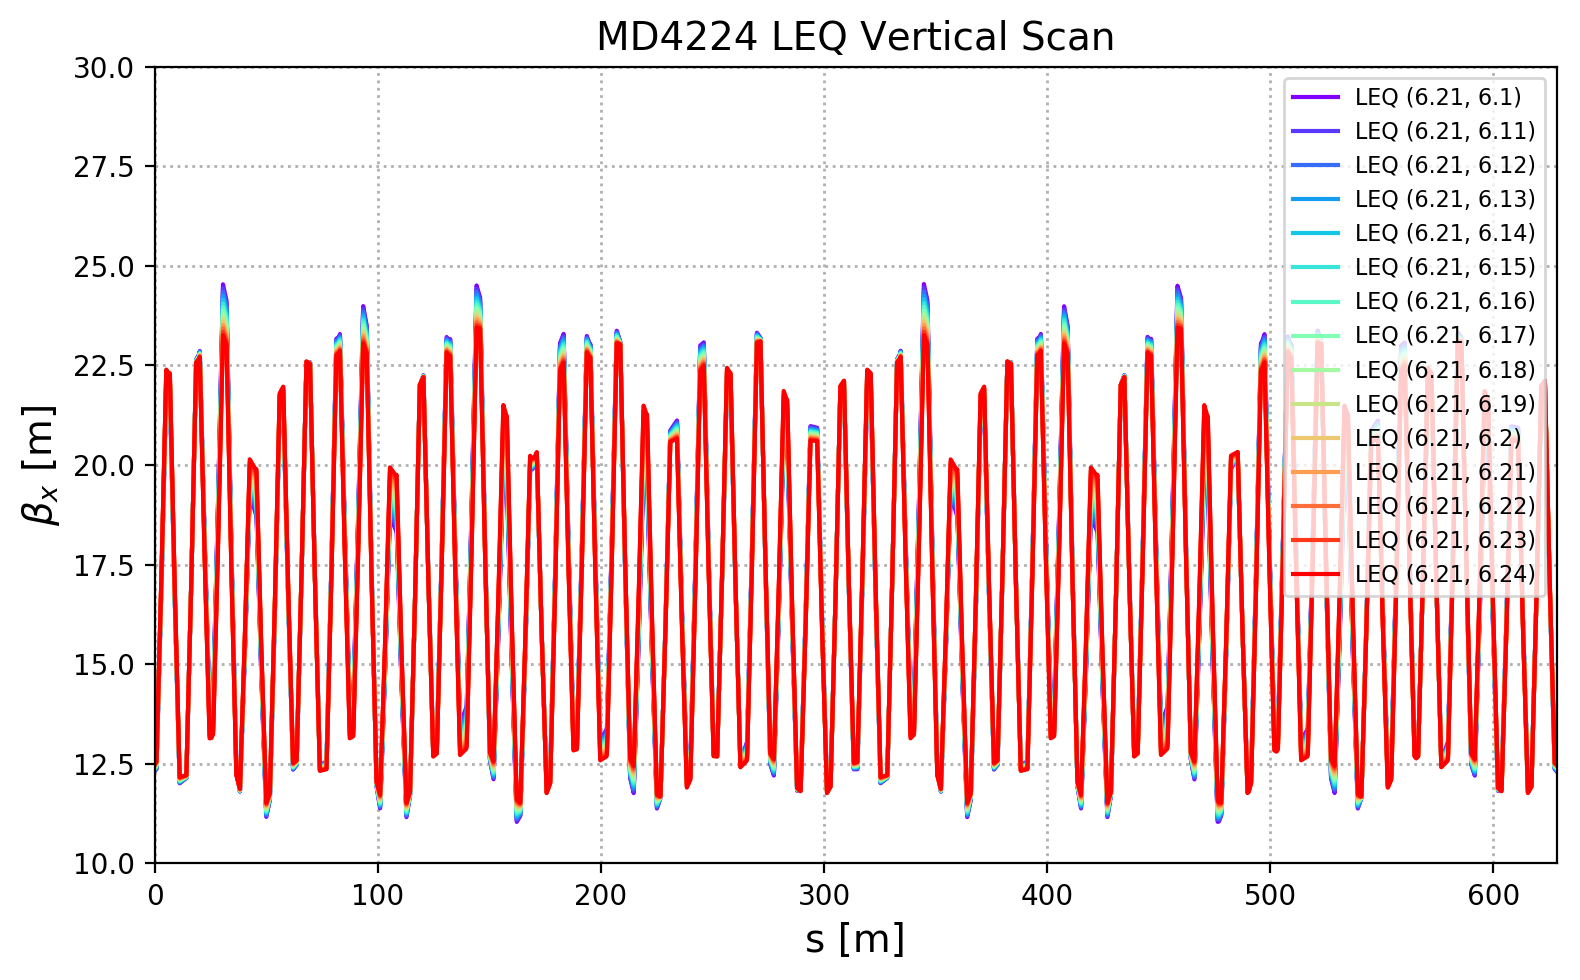

In [44]:
parameter = 'BETX'

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

tit = main_label+ ' ' + case_label
ax1.set_title(tit);

ax1.set_xlabel('s [m]');
ax1.set_ylabel(r'$\beta_x$ [m]');

colors = cm.rainbow(np.linspace(0, 1, len(LEQ_V_List)))
c_it = int(0)
for d in LEQ_V_List:
    lab_ =  'LEQ (' + str(6+round_sig(d['HEADER_Q1'][0],2)) + ', ' + str(6+round_sig(d['HEADER_Q2'][0],2)) + ')'
    ax1.plot(d['S'], d[parameter], label=lab_, color=colors[c_it]);
    c_it = c_it + 1;

ax1.legend(loc=1)
ax1.grid(lw=1, ls=':');
ax1.set_ylim(10,30)
ax1.set_xlim(0., (200.*np.pi))

savename = V_save_folder + '/'+ main_label + '_' + parameter + '.png'
plt.tight_layout()
plt.savefig(savename, dpi = 200);

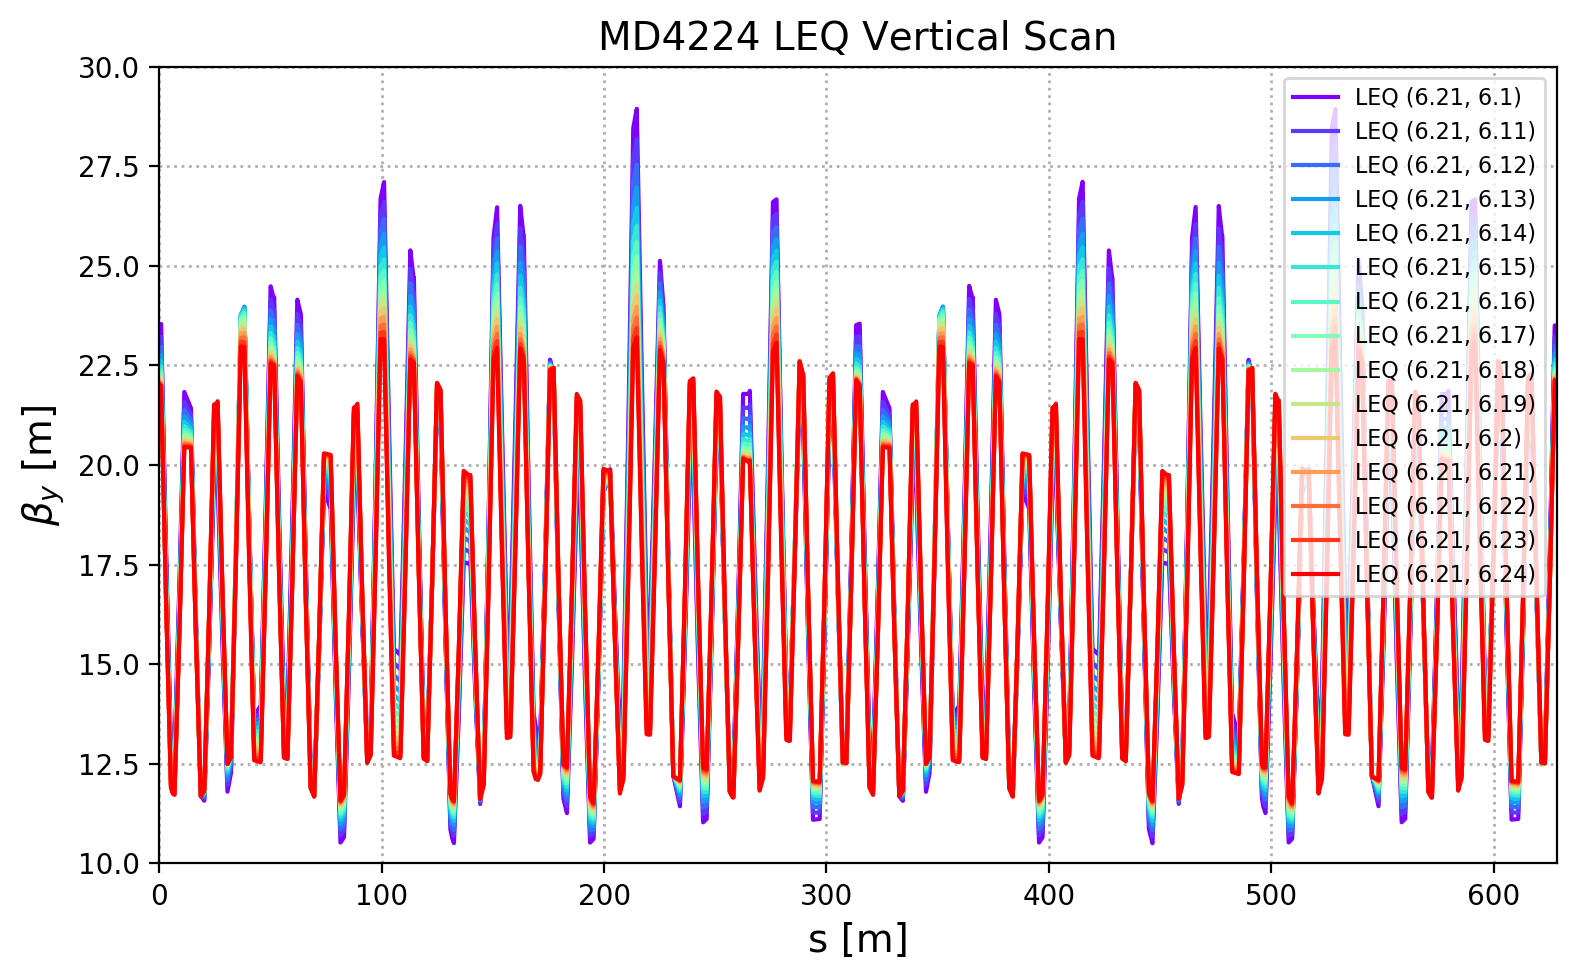

In [45]:
parameter = 'BETY'

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

tit = main_label+ ' ' + case_label
ax1.set_title(tit);

ax1.set_xlabel('s [m]');
ax1.set_ylabel(r'$\beta_y$ [m]');

colors = cm.rainbow(np.linspace(0, 1, len(LEQ_V_List)))
c_it = int(0)
for d in LEQ_V_List:
    lab_ =  'LEQ (' + str(6+round_sig(d['HEADER_Q1'][0],2)) + ', ' + str(6+round_sig(d['HEADER_Q2'][0],2)) + ')'
    ax1.plot(d['S'], d[parameter], label=lab_, color=colors[c_it]);
    c_it = c_it + 1;

ax1.legend(loc=1)
ax1.grid(lw=1, ls=':');
ax1.set_ylim(10,30)
ax1.set_xlim(0., (200.*np.pi))

savename = V_save_folder + '/'+ main_label + '_' + parameter + '.png'
plt.tight_layout()
plt.savefig(savename, dpi = 200);

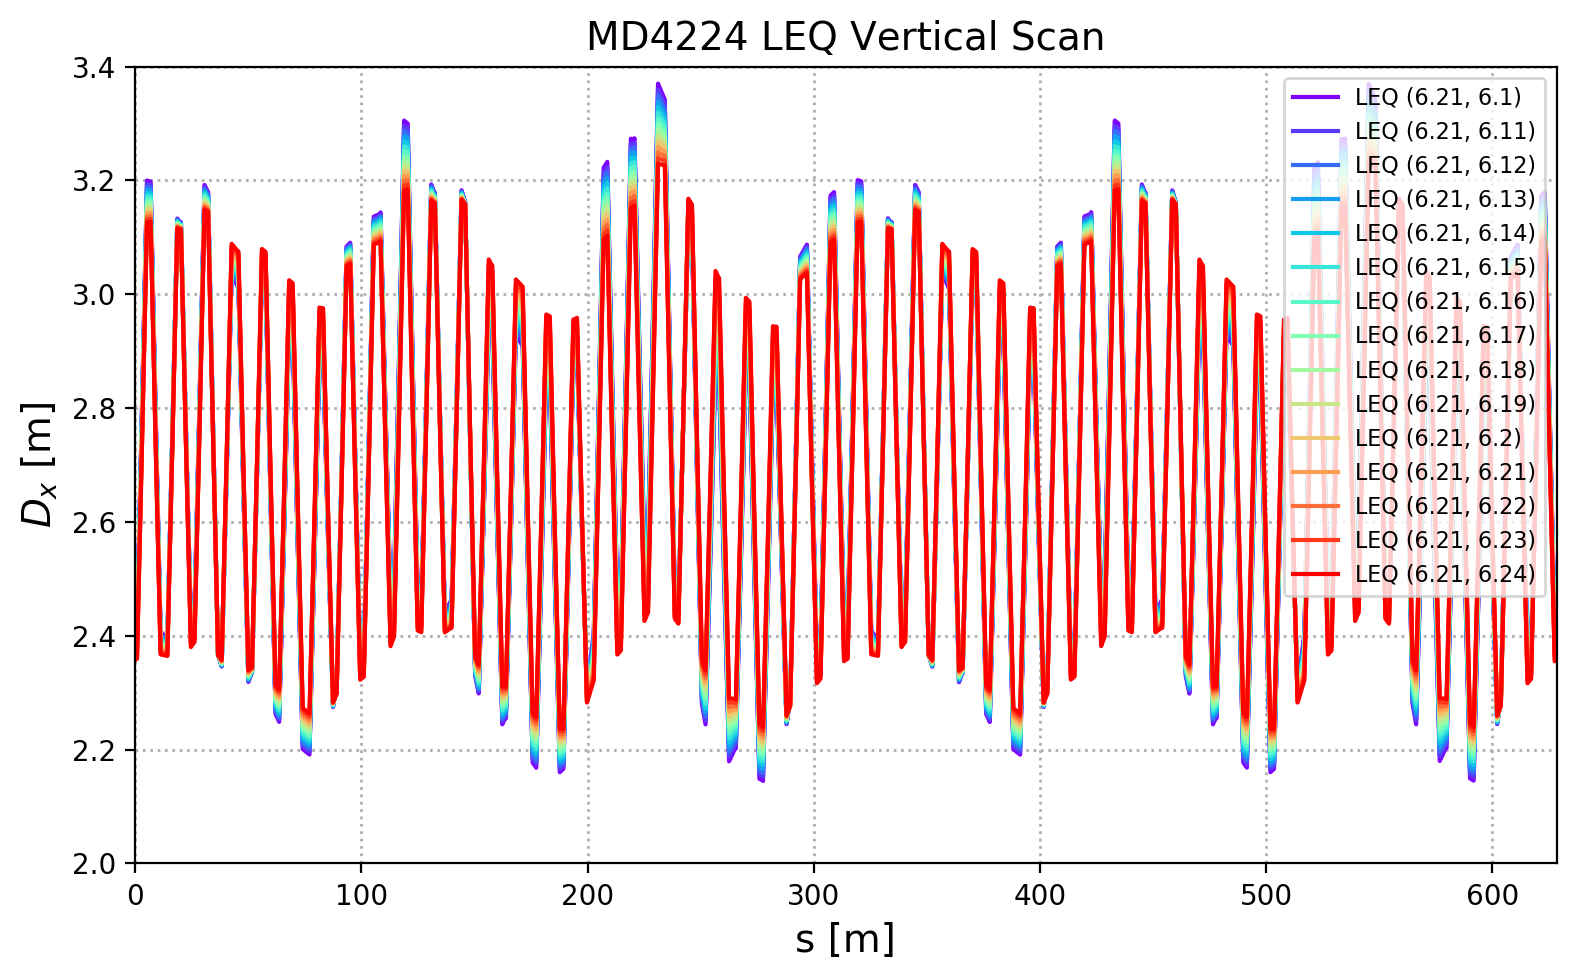

In [46]:
parameter = 'DISP1'

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

tit = main_label+ ' ' + case_label
ax1.set_title(tit);

ax1.set_xlabel('s [m]');
ax1.set_ylabel(r'$D_x$ [m]');

colors = cm.rainbow(np.linspace(0, 1, len(LEQ_V_List)))
c_it = int(0)
for d in LEQ_V_List:
    lab_ =  'LEQ (' + str(6+round_sig(d['HEADER_Q1'][0],2)) + ', ' + str(6+round_sig(d['HEADER_Q2'][0],2)) + ')'
    ax1.plot(np.array(d['S']), np.array(d[parameter])*beta, label=lab_, color=colors[c_it]);
    c_it = c_it + 1;

ax1.legend(loc=1)
ax1.grid(lw=1, ls=':');
ax1.set_ylim(2.0, 3.4)
ax1.set_xlim(0., (200.*np.pi))

savename = V_save_folder + '/'+ main_label + '_' + parameter + '.png'
plt.tight_layout()
plt.savefig(savename, dpi = 200);

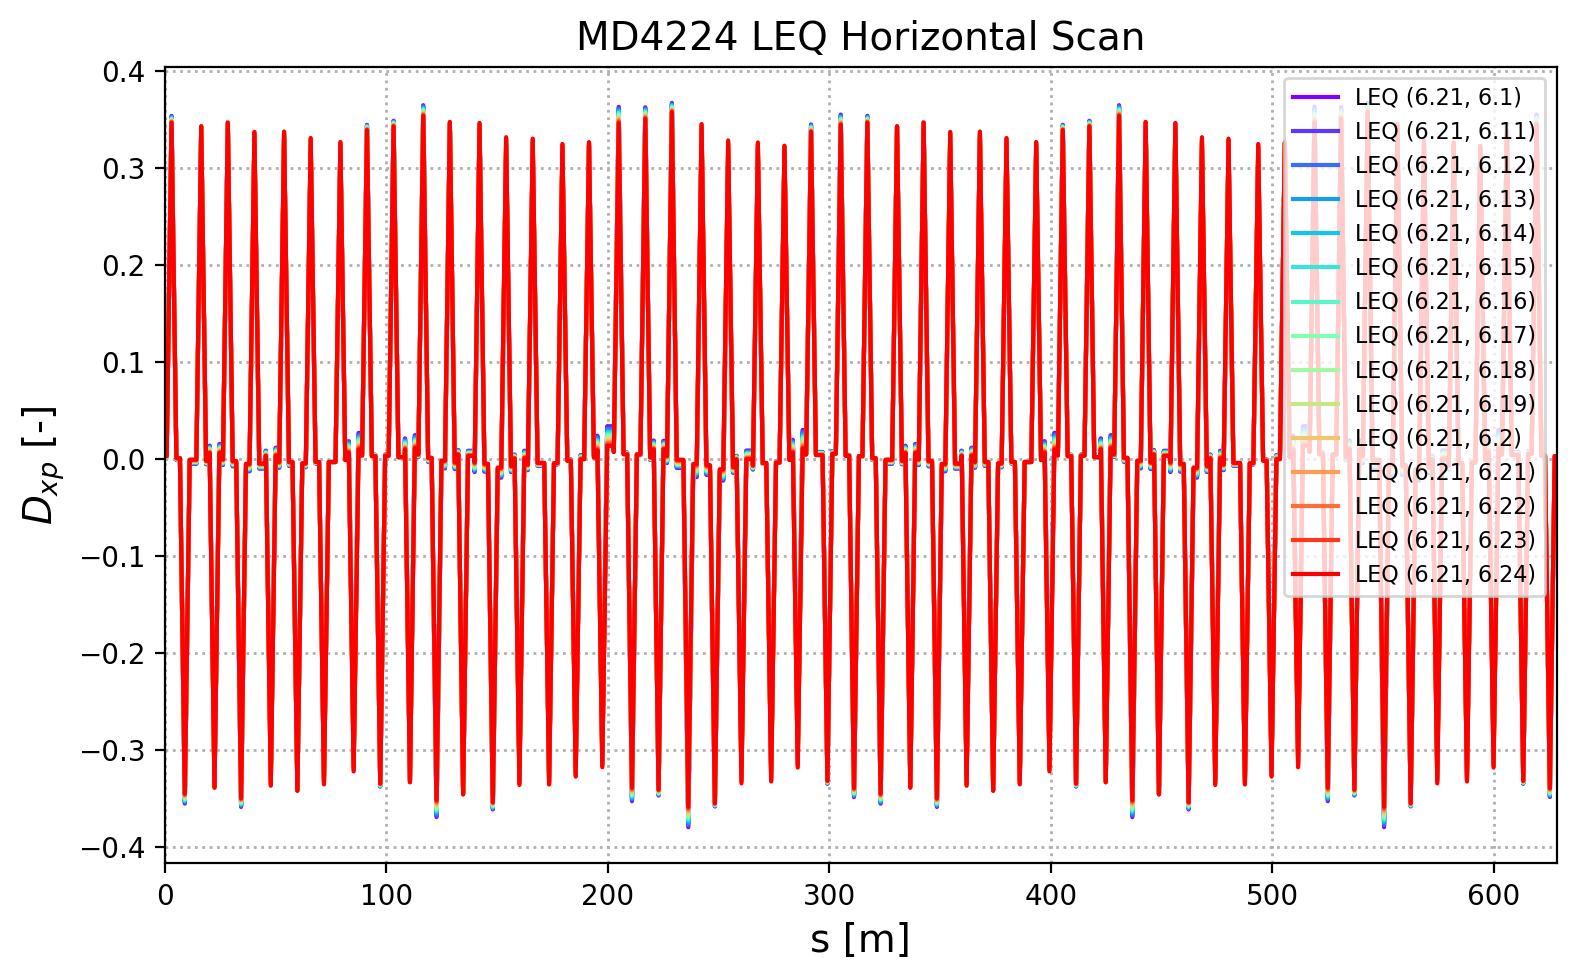

In [72]:
parameter = 'DISP2'

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

tit = main_label+ ' ' + case_label
ax1.set_title(tit);

ax1.set_xlabel('s [m]');
ax1.set_ylabel(r'$D_{xp}$ [-]');

colors = cm.rainbow(np.linspace(0, 1, len(LEQ_V_List)))
c_it = int(0)
for d in LEQ_V_List:
    lab_ =  'LEQ (' + str(6+round_sig(d['HEADER_Q1'][0],2)) + ', ' + str(6+round_sig(d['HEADER_Q2'][0],2)) + ')'
    ax1.plot(np.array(d['S']), np.array(d[parameter])*beta, label=lab_, color=colors[c_it]);
    c_it = c_it + 1;

ax1.legend(loc=1)
ax1.grid(lw=1, ls=':');
#ax1.set_ylim(2.0, 3.4)
ax1.set_xlim(0., (200.*np.pi))

savename = V_save_folder + '/'+ main_label + '_' + parameter + '.png'
plt.tight_layout()
plt.savefig(savename, dpi = 200);

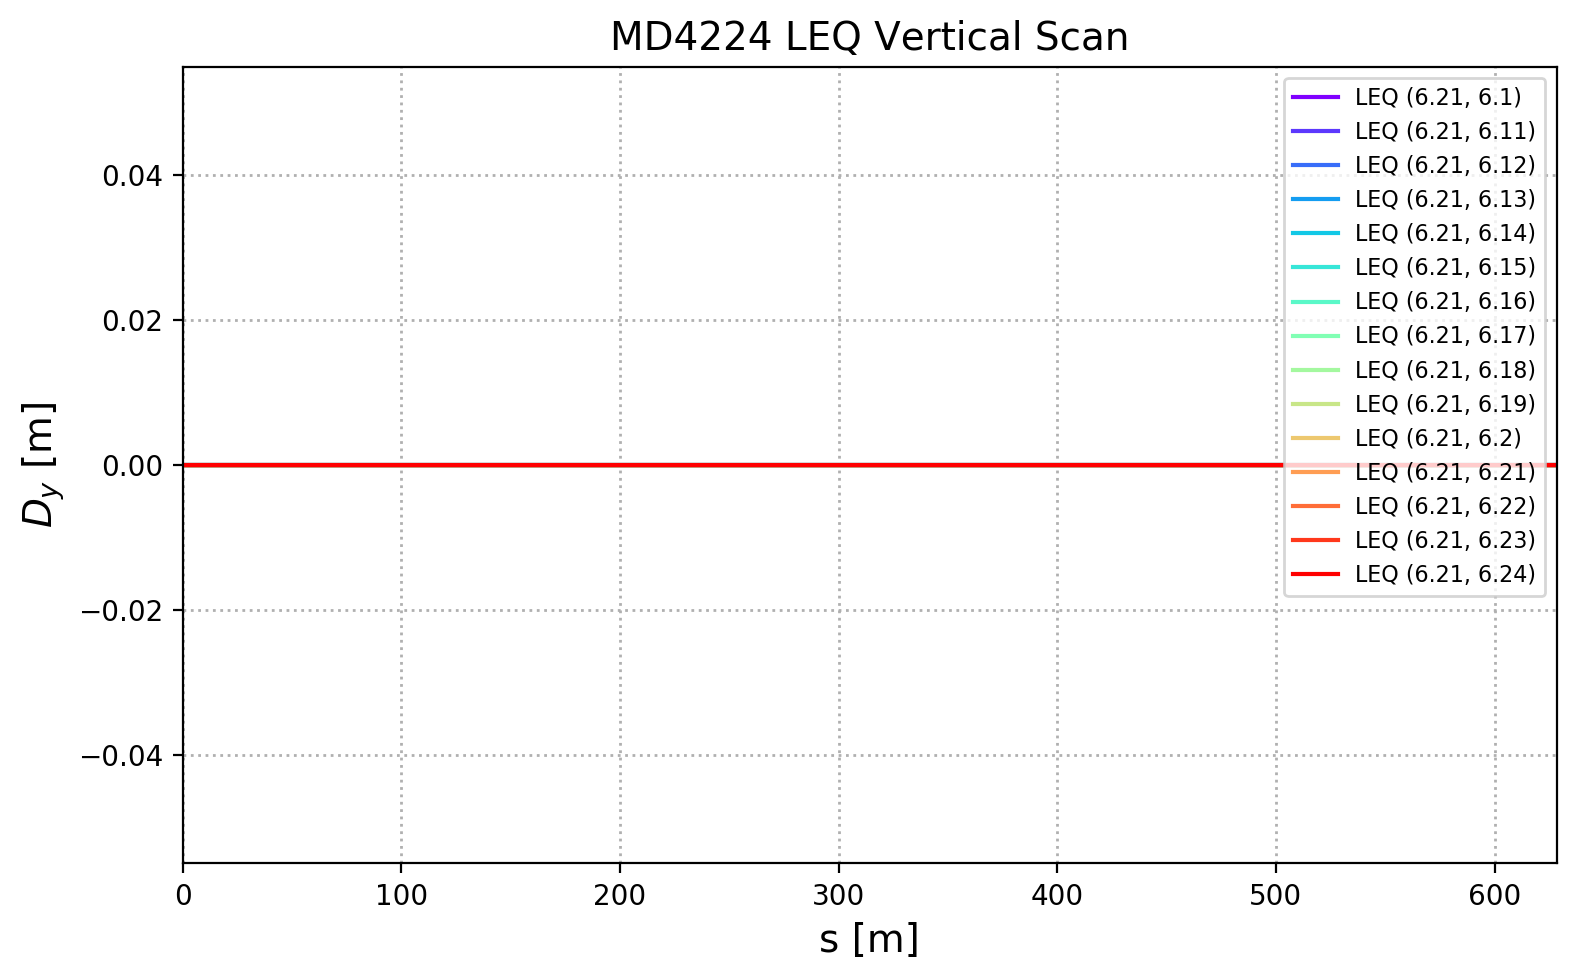

In [48]:
parameter = 'DISP3'

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

tit = main_label+ ' ' + case_label 
ax1.set_title(tit);

ax1.set_xlabel('s [m]');
ax1.set_ylabel(r'$D_y$ [m]');

colors = cm.rainbow(np.linspace(0, 1, len(LEQ_V_List)))
c_it = int(0)
for d in LEQ_V_List:
    lab_ =  'LEQ (' + str(6+round_sig(d['HEADER_Q1'][0],2)) + ', ' + str(6+round_sig(d['HEADER_Q2'][0],2)) + ')'
    ax1.plot(np.array(d['S']), np.array(d[parameter])*beta, label=lab_, color=colors[c_it]);
    c_it = c_it + 1;

ax1.legend(loc=1)
ax1.grid(lw=1, ls=':');
ax1.set_xlim(0., (200.*np.pi))

savename = V_save_folder + '/'+ main_label + '_' + parameter + '.png'
plt.tight_layout()
plt.savefig(savename, dpi = 200);

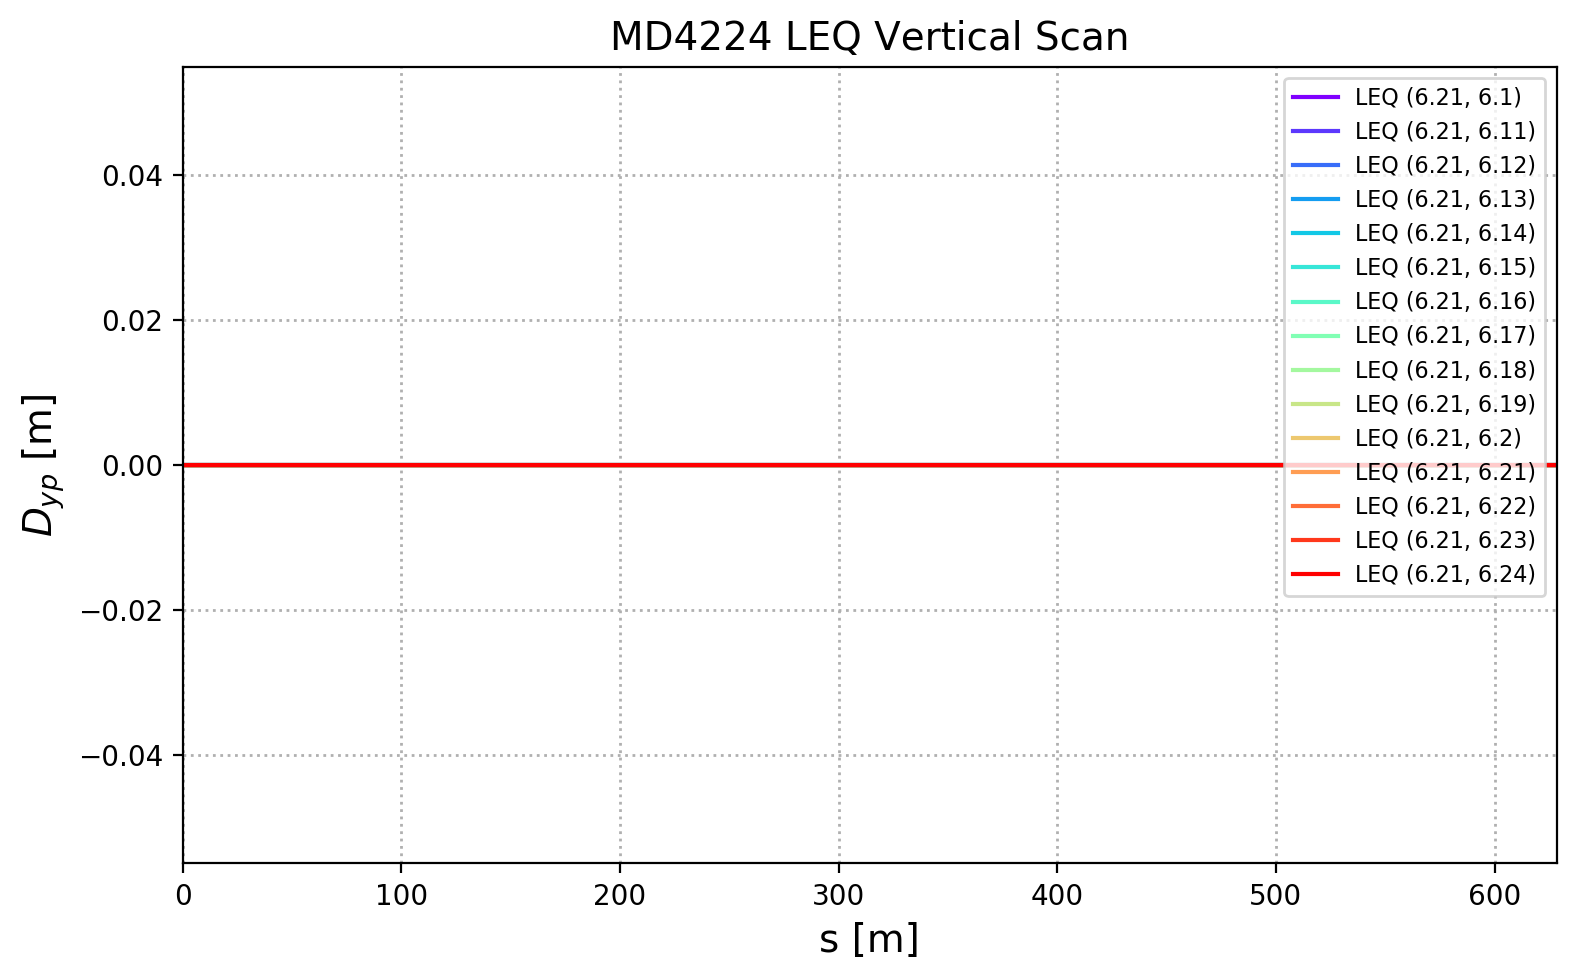

In [49]:
parameter = 'DISP4'

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

tit = main_label+ ' ' + case_label 
ax1.set_title(tit);

ax1.set_xlabel('s [m]');
ax1.set_ylabel(r'$D_{yp}$ [-]');

colors = cm.rainbow(np.linspace(0, 1, len(LEQ_V_List)))
c_it = int(0)
for d in LEQ_V_List:
    lab_ =  'LEQ (' + str(6+round_sig(d['HEADER_Q1'][0],2)) + ', ' + str(6+round_sig(d['HEADER_Q2'][0],2)) + ')'
    ax1.plot(np.array(d['S']), np.array(d[parameter])*beta, label=lab_, color=colors[c_it]);
    c_it = c_it + 1;

ax1.legend(loc=1)
ax1.grid(lw=1, ls=':');
ax1.set_xlim(0., (200.*np.pi))

savename = V_save_folder + '/'+ main_label + '_' + parameter + '.png'
plt.tight_layout()
plt.savefig(savename, dpi = 200);

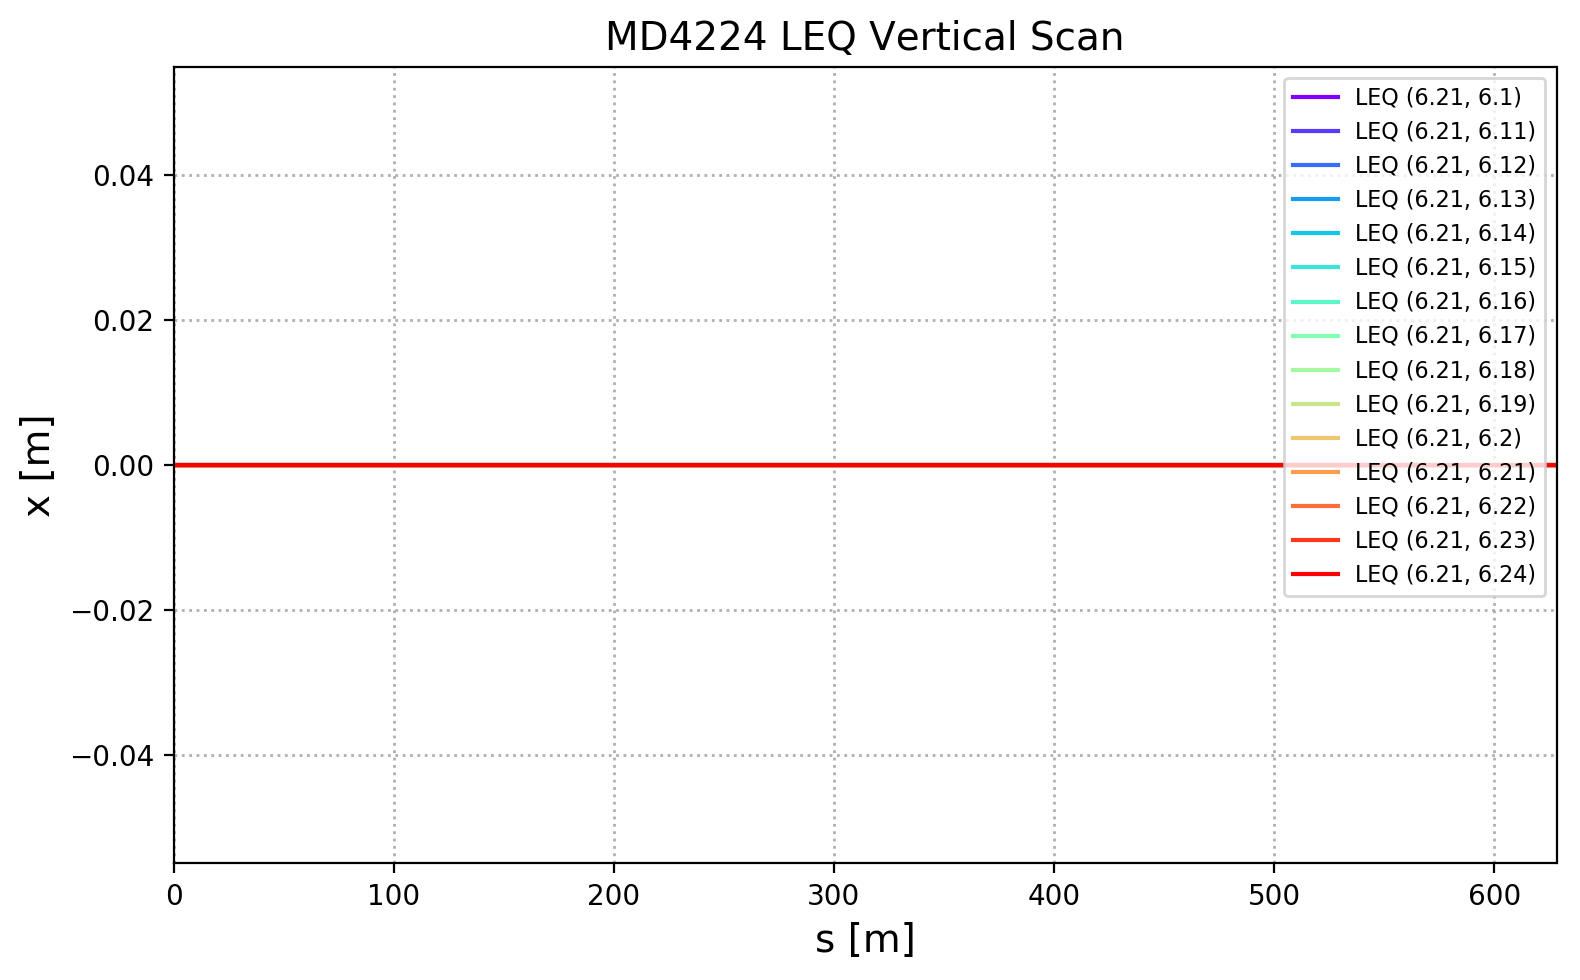

In [50]:
parameter = 'X'

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

tit = main_label+ ' ' + case_label 
ax1.set_title(tit);

ax1.set_xlabel('s [m]');
ax1.set_ylabel('x [m]');

colors = cm.rainbow(np.linspace(0, 1, len(LEQ_V_List)))
c_it = int(0)
for d in LEQ_V_List:
    lab_ =  'LEQ (' + str(6+round_sig(d['HEADER_Q1'][0],2)) + ', ' + str(6+round_sig(d['HEADER_Q2'][0],2)) + ')'
    ax1.plot(d['S'], d[parameter], label=lab_, color=colors[c_it]);
    c_it = c_it + 1;

ax1.legend(loc=1)
ax1.grid(lw=1, ls=':');
ax1.set_xlim(0., (200.*np.pi))

savename = V_save_folder + '/'+ main_label + '_' + parameter + '.png'
plt.tight_layout()
plt.savefig(savename, dpi = 200);

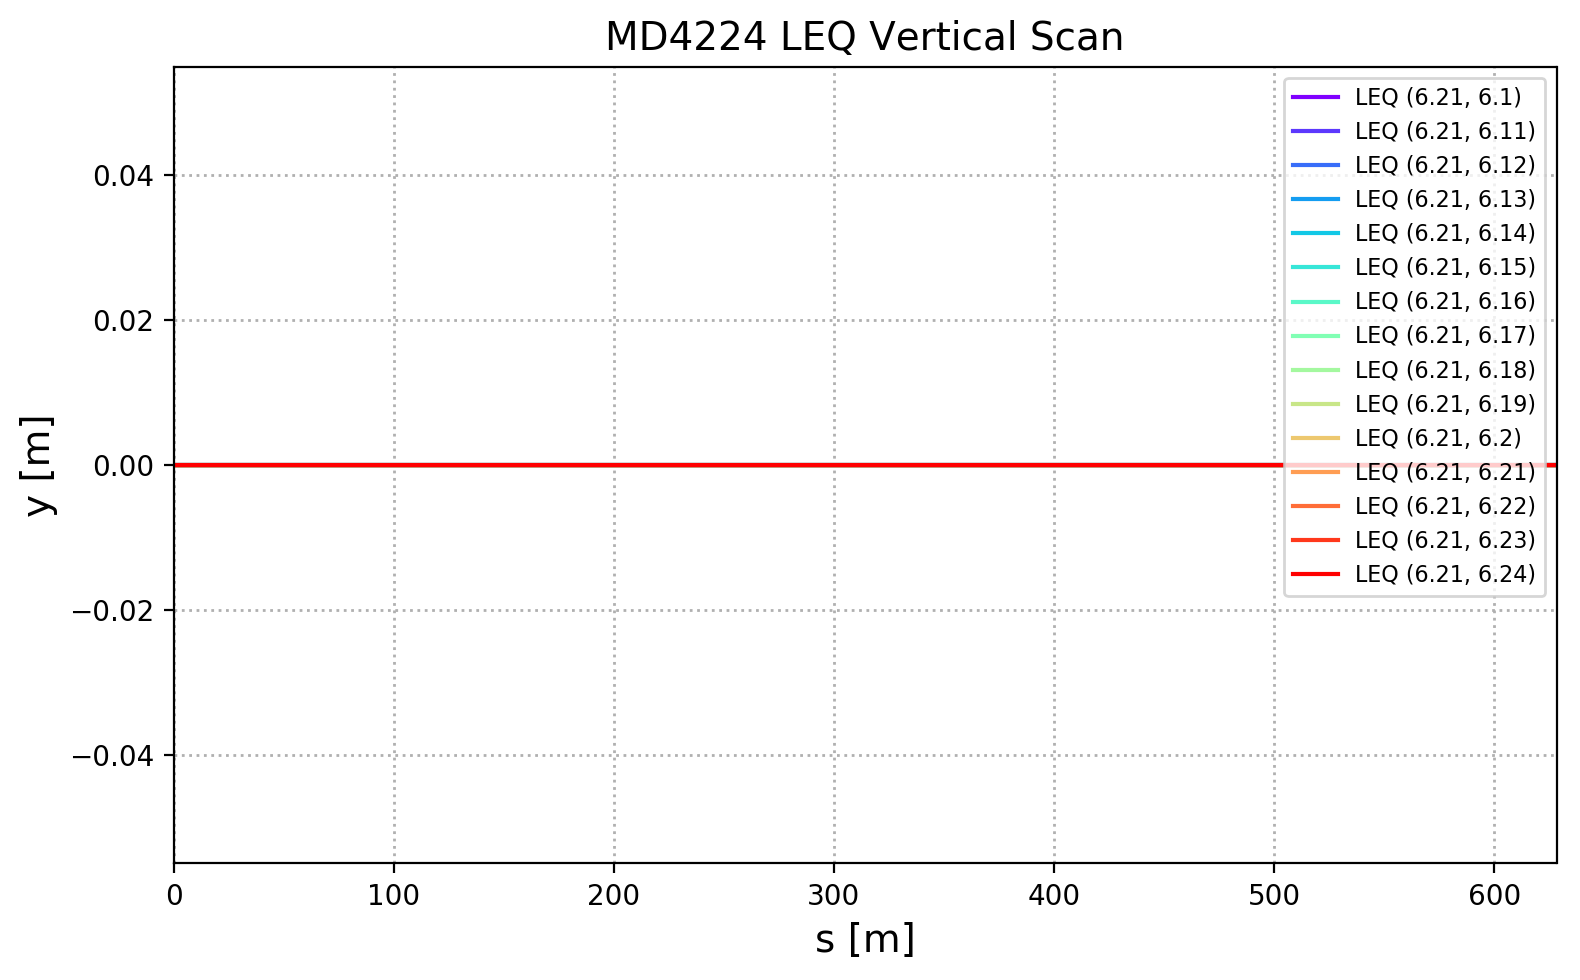

In [51]:
parameter = 'Y'

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

tit = main_label+ ' ' + case_label 
ax1.set_title(tit);

ax1.set_xlabel('s [m]');
ax1.set_ylabel('y [m]');

colors = cm.rainbow(np.linspace(0, 1, len(LEQ_V_List)))
c_it = int(0)
for d in LEQ_V_List:
    lab_ =  'LEQ (' + str(6+round_sig(d['HEADER_Q1'][0],2)) + ', ' + str(6+round_sig(d['HEADER_Q2'][0],2)) + ')'
    ax1.plot(d['S'], d[parameter], label=lab_, color=colors[c_it]);
    c_it = c_it + 1;

ax1.legend(loc=1)
ax1.grid(lw=1, ls=':');
ax1.set_xlim(0., (200.*np.pi))

savename = V_save_folder + '/'+ main_label + '_' + parameter + '.png'
plt.tight_layout()
plt.savefig(savename, dpi = 200);

### LEQ Horizontal

In [63]:
main_label = 'MD4224'
case_label = 'LEQ Horizontal Scan'
Hsave_folder = 'LEQ_Horizontal'
make_directory(Hsave_folder)

Creation of the directory LEQ_Horizontal failed


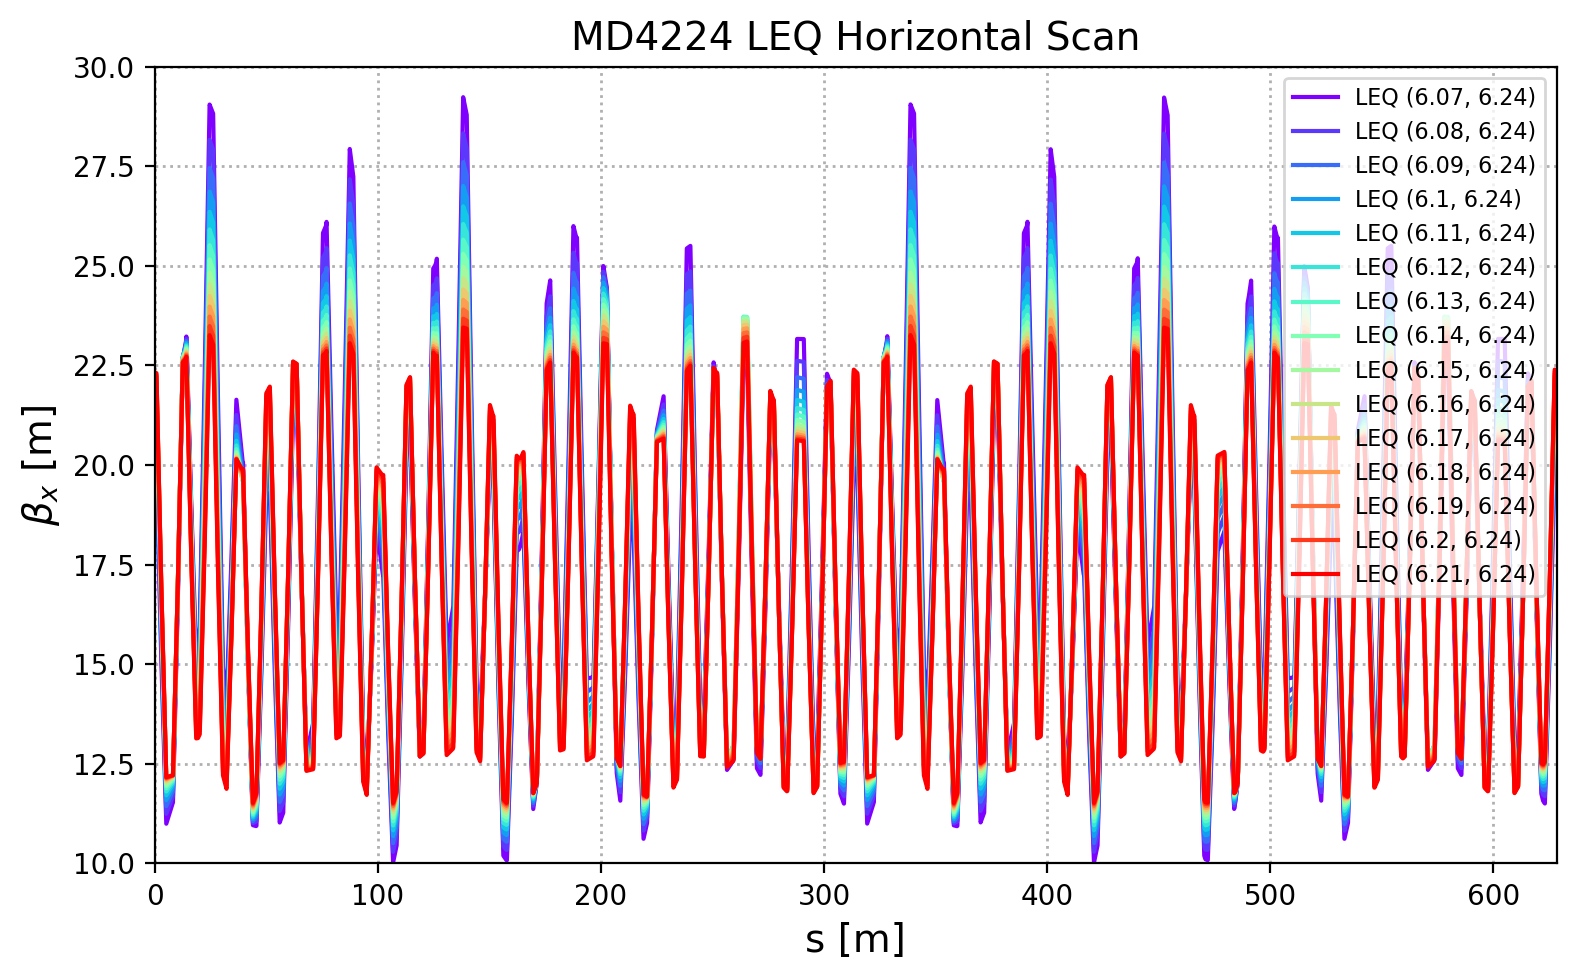

In [64]:
parameter = 'BETX'

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

tit = main_label+ ' ' + case_label
ax1.set_title(tit);

ax1.set_xlabel('s [m]');
ax1.set_ylabel(r'$\beta_x$ [m]');

colors = cm.rainbow(np.linspace(0, 1, len(LEQ_H_List)))
c_it = int(0)
for d in LEQ_H_List:
    lab_ =  'LEQ (' + str(6+round_sig(d['HEADER_Q1'][0],2)) + ', ' + str(6+round_sig(d['HEADER_Q2'][0],2)) + ')'
    ax1.plot(d['S'], d[parameter], label=lab_, color=colors[c_it]);
    c_it = c_it + 1;

ax1.legend(loc=1)
ax1.grid(lw=1, ls=':');
ax1.set_ylim(10,30)
ax1.set_xlim(0., (200.*np.pi))

savename = Hsave_folder + '/'+ main_label + '_' + parameter + '.png'
plt.tight_layout()
plt.savefig(savename, dpi = 200);

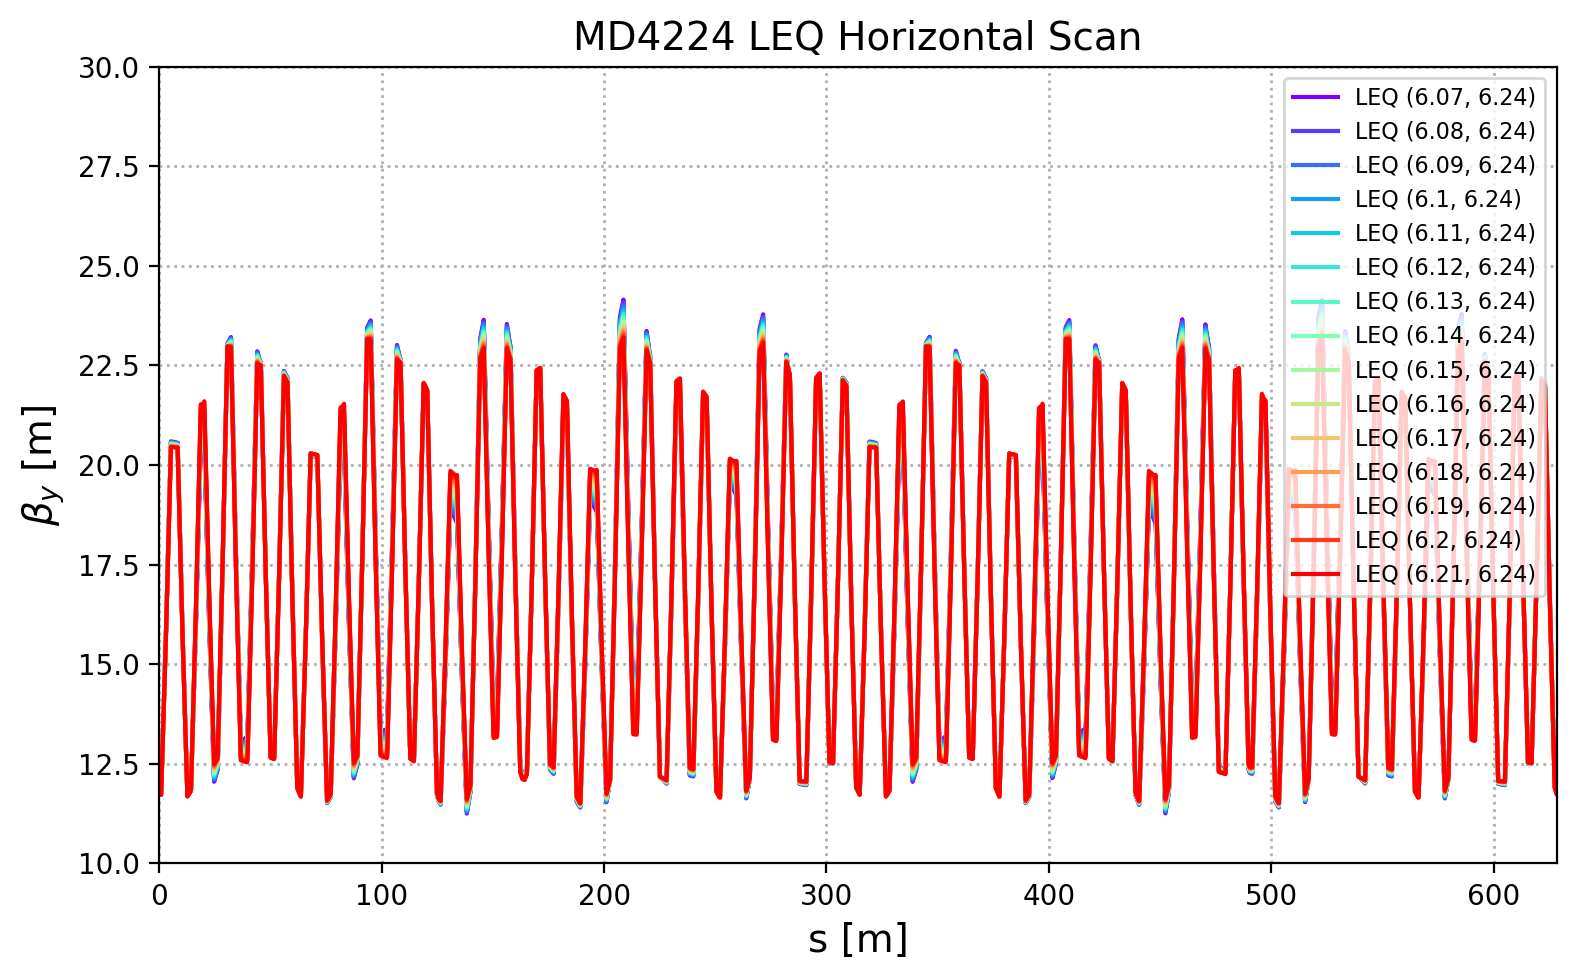

In [65]:
parameter = 'BETY'

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

tit = main_label+ ' ' + case_label
ax1.set_title(tit);

ax1.set_xlabel('s [m]');
ax1.set_ylabel(r'$\beta_y$ [m]');

colors = cm.rainbow(np.linspace(0, 1, len(LEQ_H_List)))
c_it = int(0)
for d in LEQ_H_List:
    lab_ =  'LEQ (' + str(6+round_sig(d['HEADER_Q1'][0],2)) + ', ' + str(6+round_sig(d['HEADER_Q2'][0],2)) + ')'
    ax1.plot(d['S'], d[parameter], label=lab_, color=colors[c_it]);
    c_it = c_it + 1;

ax1.legend(loc=1)
ax1.grid(lw=1, ls=':');
ax1.set_ylim(10,30)
ax1.set_xlim(0., (200.*np.pi))

savename = Hsave_folder + '/'+ main_label + '_' + parameter + '.png'
plt.tight_layout()
plt.savefig(savename, dpi = 200);

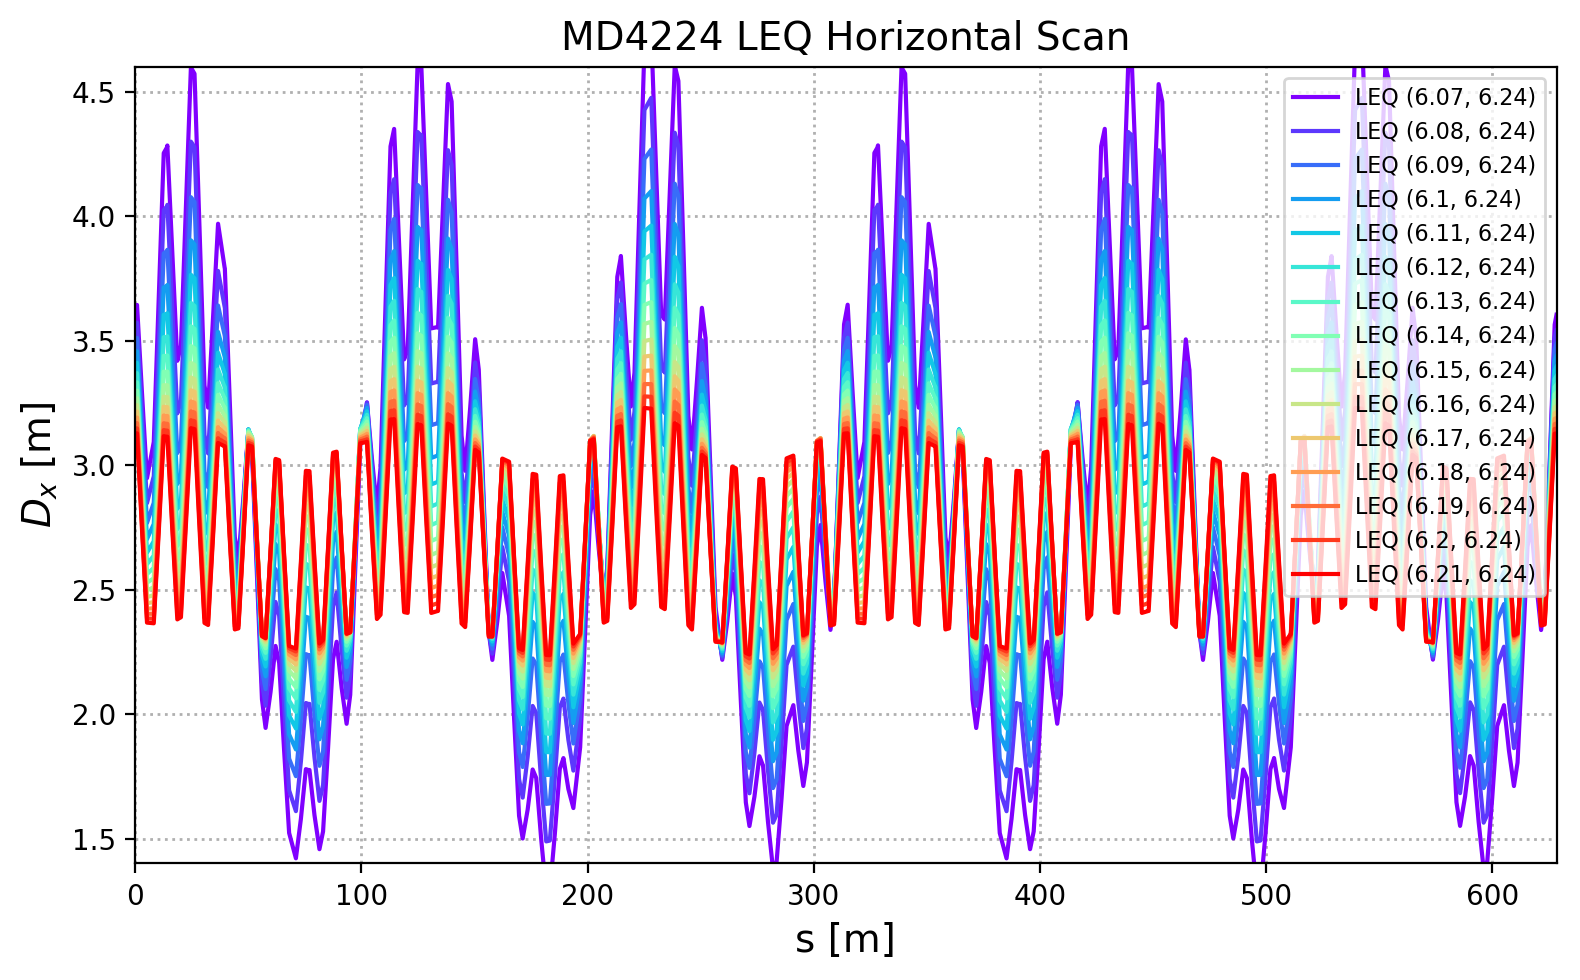

In [66]:
parameter = 'DISP1'

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

tit = main_label+ ' ' + case_label
ax1.set_title(tit);

ax1.set_xlabel('s [m]');
ax1.set_ylabel(r'$D_x$ [m]');

colors = cm.rainbow(np.linspace(0, 1, len(LEQ_H_List)))
c_it = int(0)
for d in LEQ_H_List:
    lab_ =  'LEQ (' + str(6+round_sig(d['HEADER_Q1'][0],2)) + ', ' + str(6+round_sig(d['HEADER_Q2'][0],2)) + ')'
    ax1.plot(np.array(d['S']), np.array(d[parameter])*beta, label=lab_, color=colors[c_it]);
    c_it = c_it + 1;

ax1.legend(loc=1)
ax1.grid(lw=1, ls=':');
ax1.set_ylim(1.4, 4.6)
ax1.set_xlim(0., (200.*np.pi))

savename = Hsave_folder + '/'+ main_label + '_' + parameter + '.png'
plt.tight_layout()
plt.savefig(savename, dpi = 200);

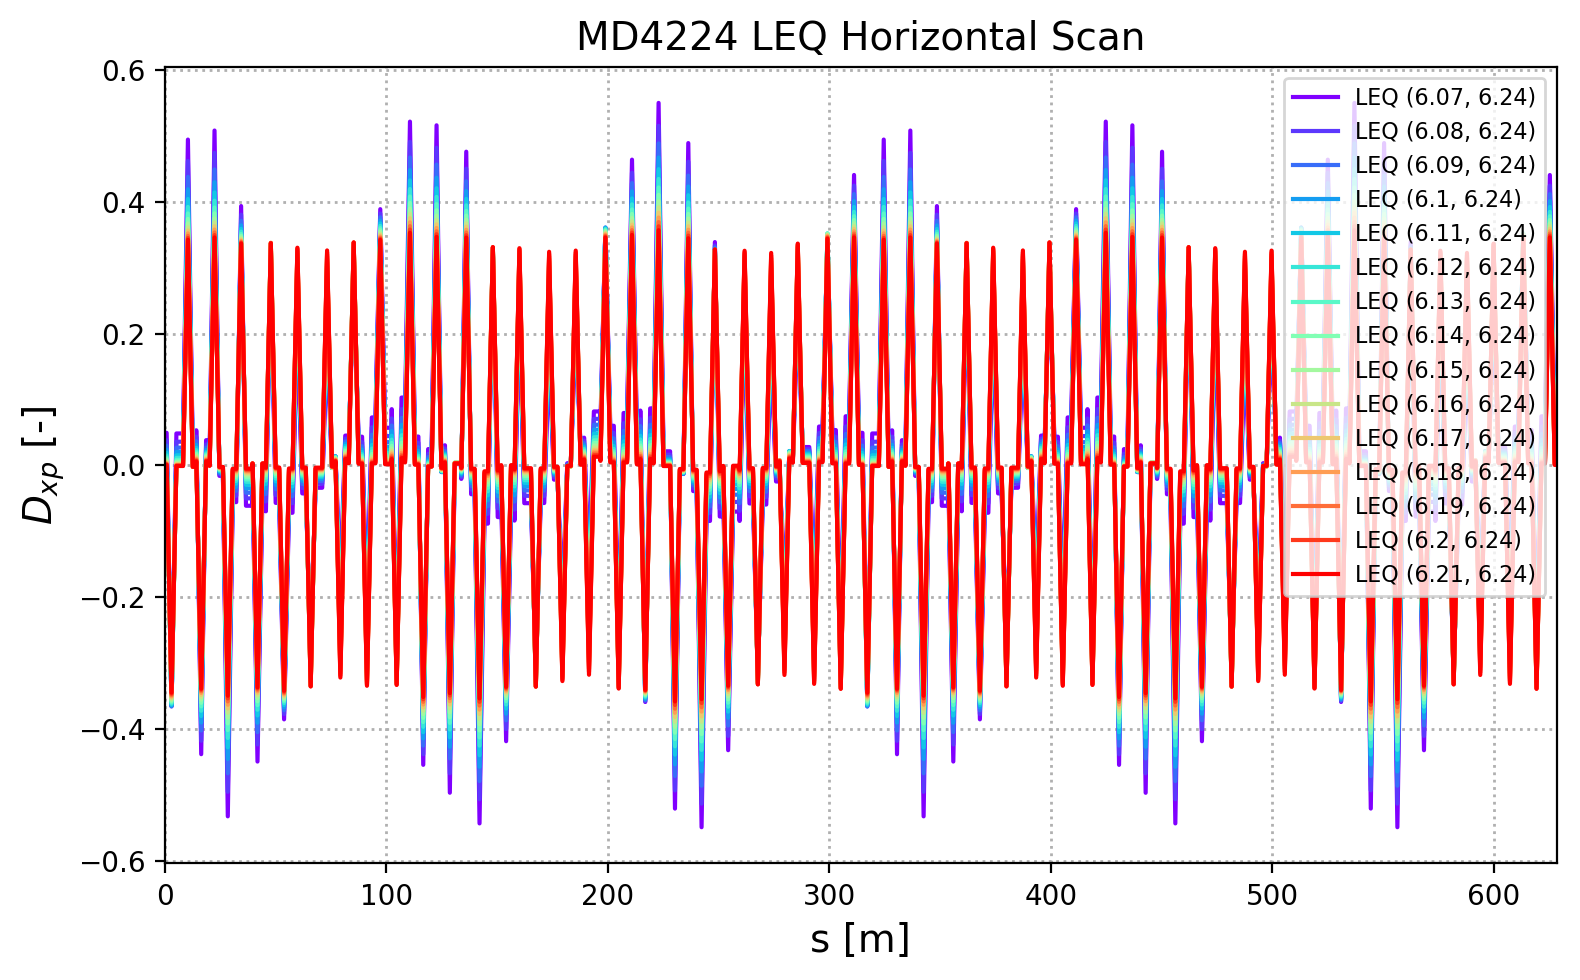

In [73]:
parameter = 'DISP2'

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

tit = main_label+ ' ' + case_label
ax1.set_title(tit);

ax1.set_xlabel('s [m]');
ax1.set_ylabel(r'$D_{xp}$ [-]');

colors = cm.rainbow(np.linspace(0, 1, len(LEQ_H_List)))
c_it = int(0)
for d in LEQ_H_List:
    lab_ =  'LEQ (' + str(6+round_sig(d['HEADER_Q1'][0],2)) + ', ' + str(6+round_sig(d['HEADER_Q2'][0],2)) + ')'
    ax1.plot(np.array(d['S']), np.array(d[parameter])*beta, label=lab_, color=colors[c_it]);
    c_it = c_it + 1;

ax1.legend(loc=1)
ax1.grid(lw=1, ls=':');
#ax1.set_ylim(1.4, 4.6)
ax1.set_xlim(0., (200.*np.pi))

savename = Hsave_folder + '/'+ main_label + '_' + parameter + '.png'
plt.tight_layout()
plt.savefig(savename, dpi = 200);

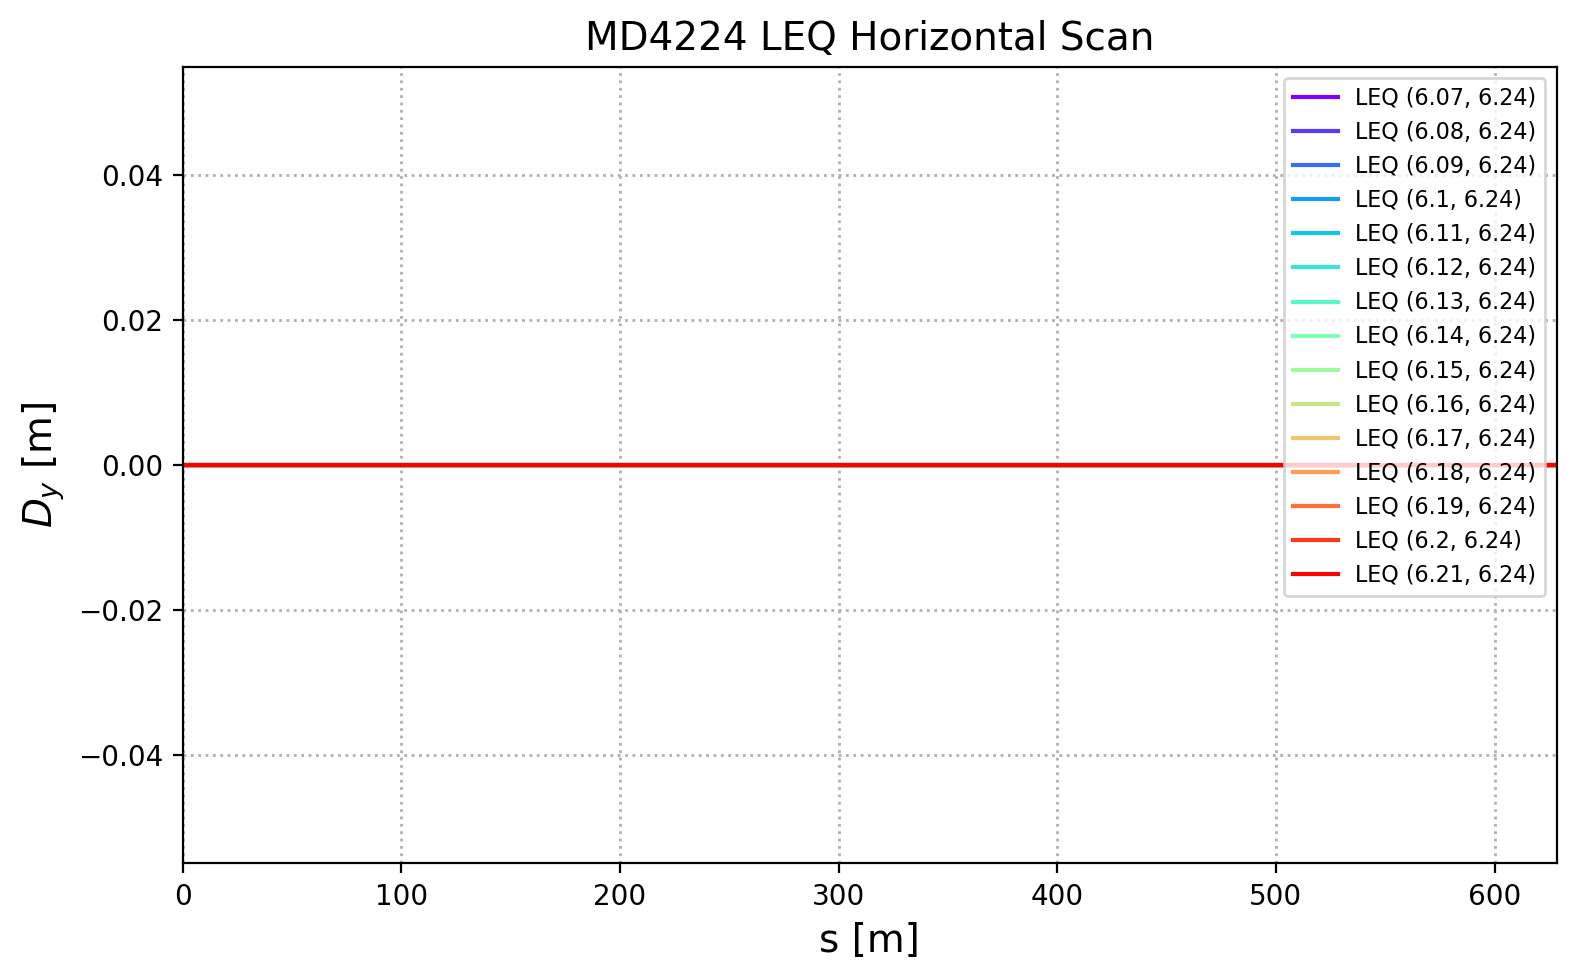

In [68]:
parameter = 'DISP3'

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

tit = main_label+ ' ' + case_label
ax1.set_title(tit);

ax1.set_xlabel('s [m]');
ax1.set_ylabel(r'$D_y$ [m]');

colors = cm.rainbow(np.linspace(0, 1, len(LEQ_H_List)))
c_it = int(0)
for d in LEQ_H_List:
    lab_ =  'LEQ (' + str(6+round_sig(d['HEADER_Q1'][0],2)) + ', ' + str(6+round_sig(d['HEADER_Q2'][0],2)) + ')'
    ax1.plot(np.array(d['S']), np.array(d[parameter])*beta, label=lab_, color=colors[c_it]);
    c_it = c_it + 1;

ax1.legend(loc=1)
ax1.grid(lw=1, ls=':');
#ax1.set_xlim(-10,100)
ax1.set_xlim(0., (200.*np.pi))

savename = Hsave_folder + '/'+ main_label + '_' + parameter + '.png'
plt.tight_layout()
plt.savefig(savename, dpi = 200);

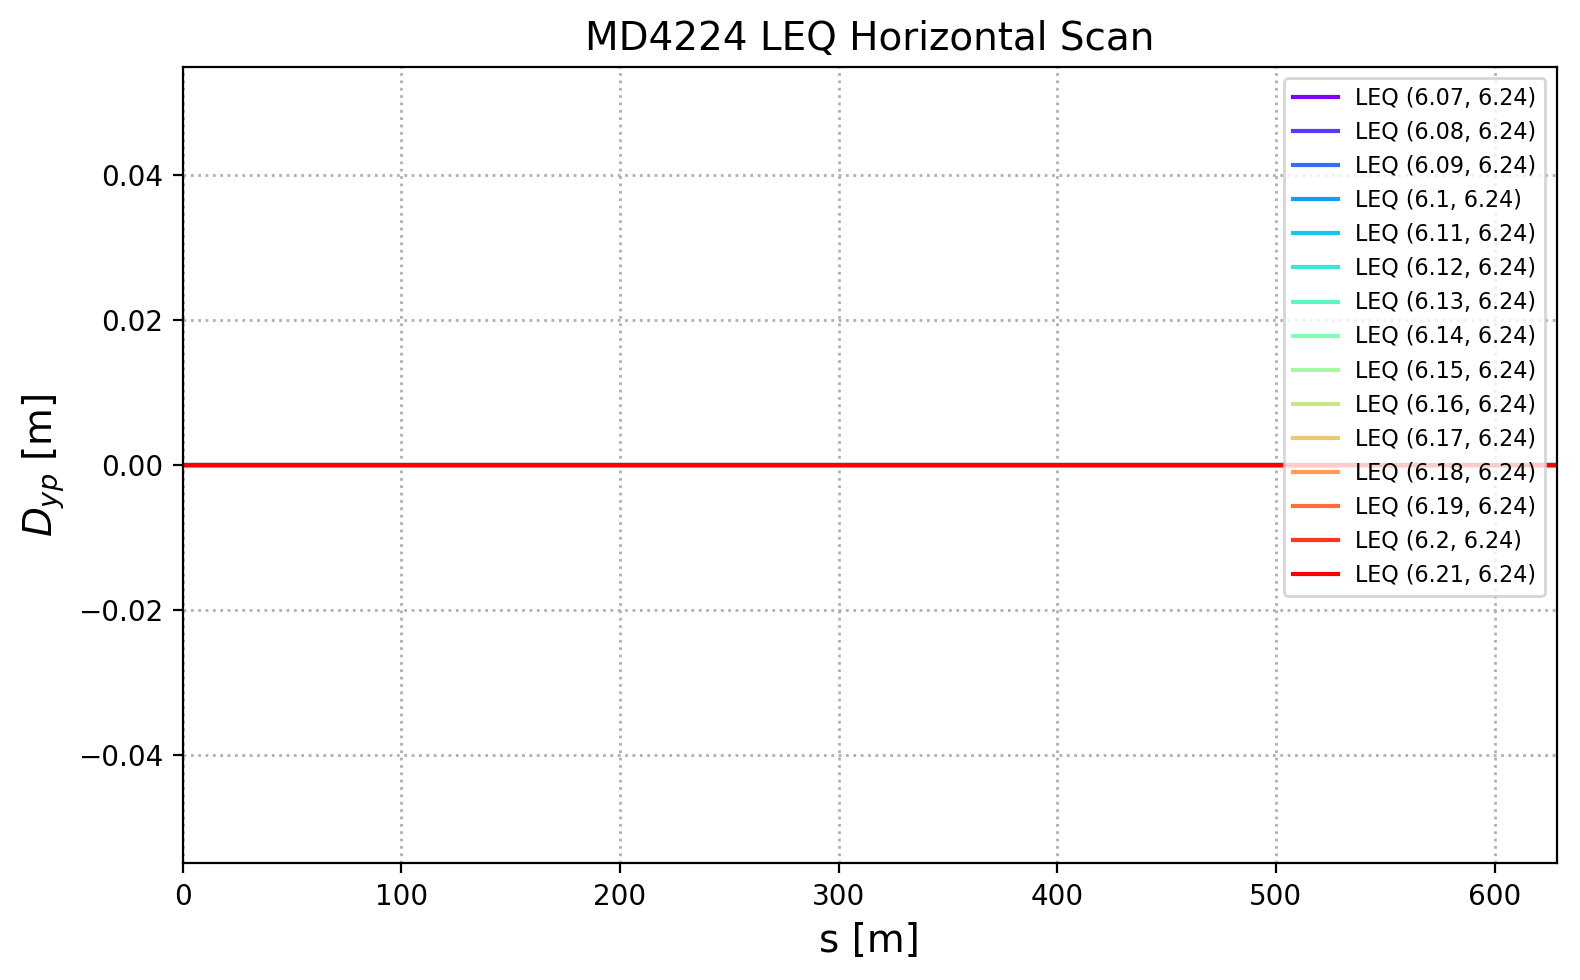

In [69]:
parameter = 'DISP4'

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

tit = main_label+ ' ' + case_label
ax1.set_title(tit);

ax1.set_xlabel('s [m]');
ax1.set_ylabel(r'$D_{yp}$ [-]');

colors = cm.rainbow(np.linspace(0, 1, len(LEQ_H_List)))
c_it = int(0)
for d in LEQ_H_List:
    lab_ =  'LEQ (' + str(6+round_sig(d['HEADER_Q1'][0],2)) + ', ' + str(6+round_sig(d['HEADER_Q2'][0],2)) + ')'
    ax1.plot(np.array(d['S']), np.array(d[parameter])*beta, label=lab_, color=colors[c_it]);
    c_it = c_it + 1;

ax1.legend(loc=1)
ax1.grid(lw=1, ls=':');
#ax1.set_xlim(-10,100)
ax1.set_xlim(0., (200.*np.pi))

savename = Hsave_folder + '/'+ main_label + '_' + parameter + '.png'
plt.tight_layout()
plt.savefig(savename, dpi = 200);

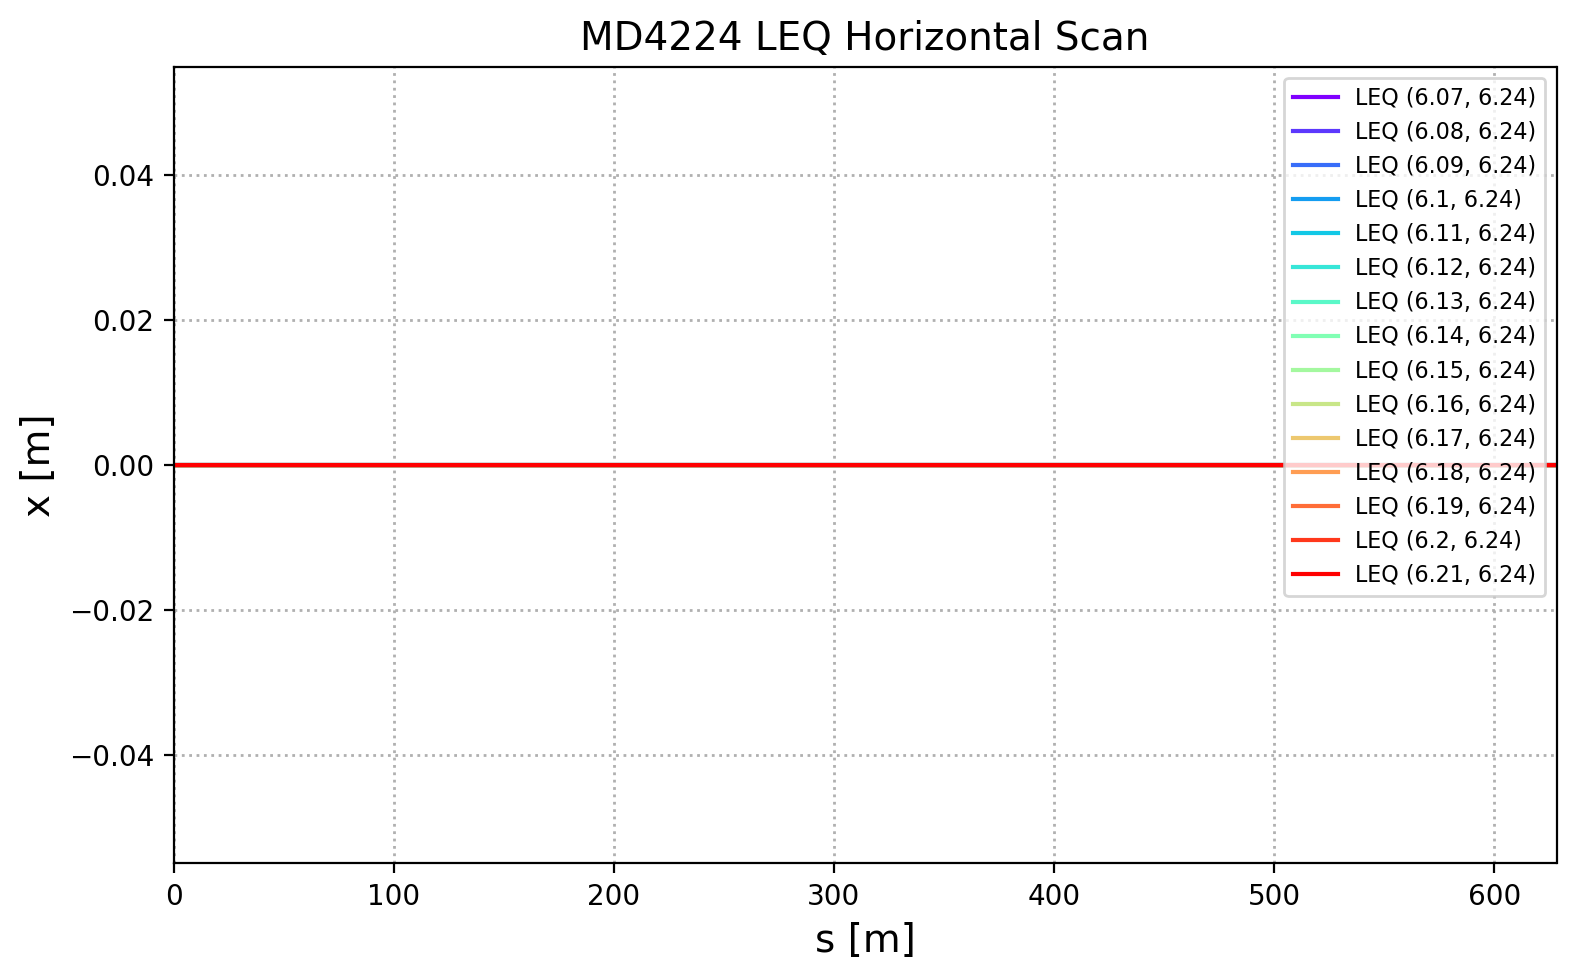

In [70]:
parameter = 'X'

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

tit = main_label+ ' ' + case_label
ax1.set_title(tit);

ax1.set_xlabel('s [m]');
ax1.set_ylabel('x [m]');

colors = cm.rainbow(np.linspace(0, 1, len(LEQ_H_List)))
c_it = int(0)
for d in LEQ_H_List:
    lab_ =  'LEQ (' + str(6+round_sig(d['HEADER_Q1'][0],2)) + ', ' + str(6+round_sig(d['HEADER_Q2'][0],2)) + ')'
    ax1.plot(d['S'], d[parameter], label=lab_, color=colors[c_it]);
    c_it = c_it + 1;

ax1.legend(loc=1)
ax1.grid(lw=1, ls=':');
#ax1.set_xlim(-10,100)
ax1.set_xlim(0., (200.*np.pi))

savename = Hsave_folder + '/'+ main_label + '_' + parameter + '.png'
plt.tight_layout()
plt.savefig(savename, dpi = 200);

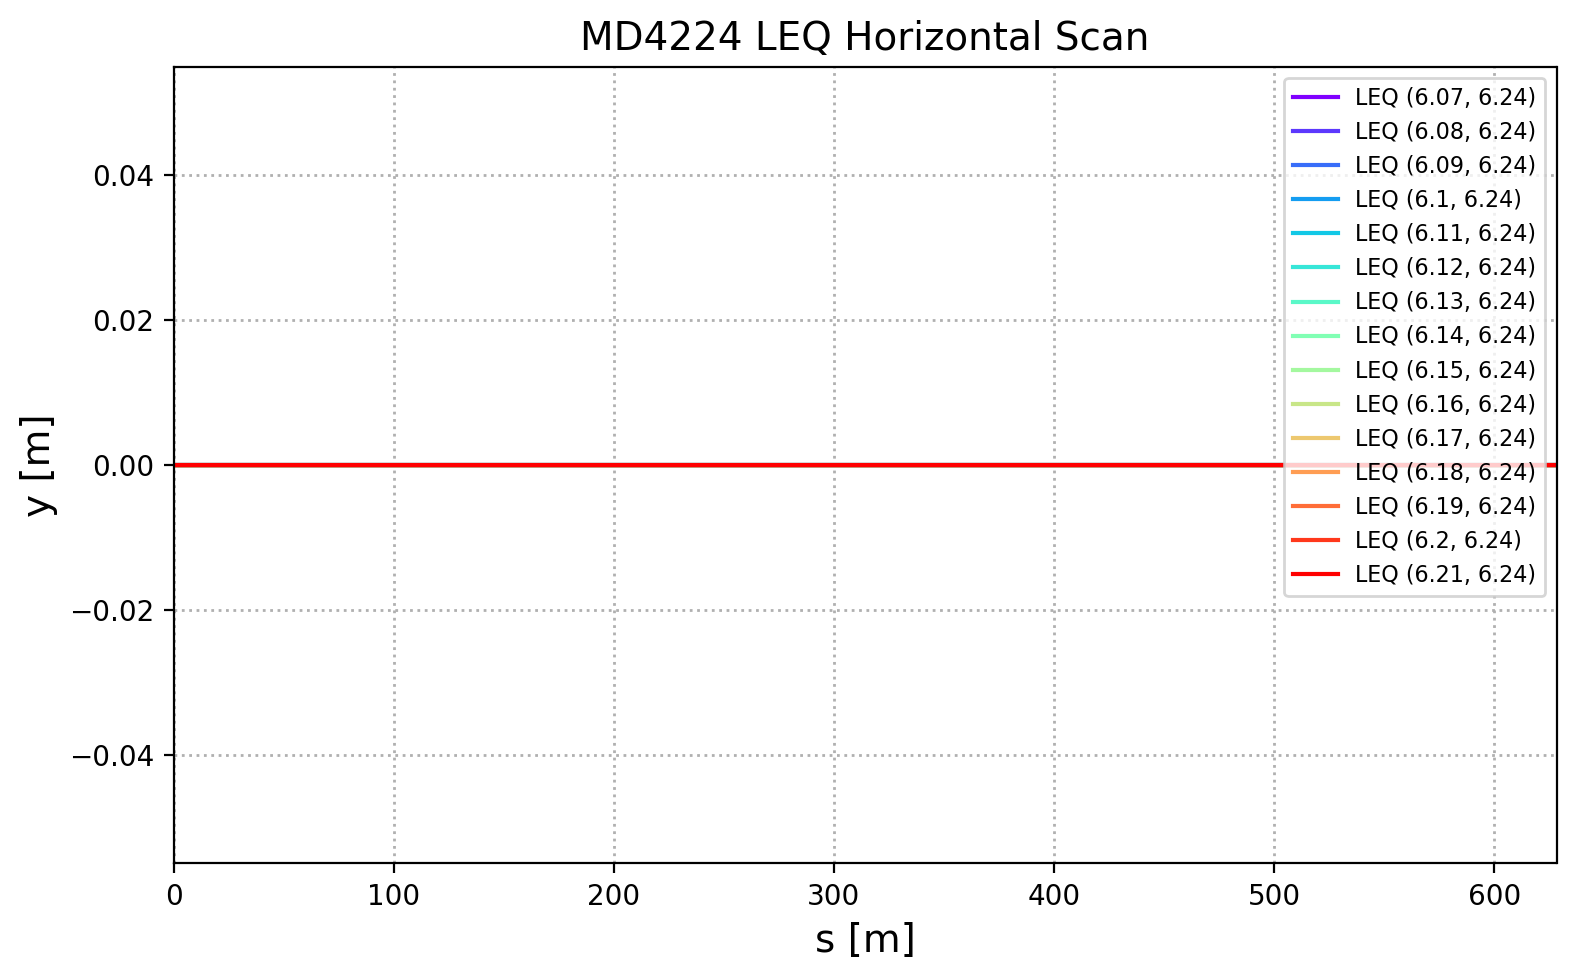

In [71]:
parameter = 'Y'

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

tit = main_label+ ' ' + case_label
ax1.set_title(tit);

ax1.set_xlabel('s [m]');
ax1.set_ylabel('y [m]');

colors = cm.rainbow(np.linspace(0, 1, len(LEQ_H_List)))
c_it = int(0)
for d in LEQ_H_List:
    lab_ =  'LEQ (' + str(6+round_sig(d['HEADER_Q1'][0],2)) + ', ' + str(6+round_sig(d['HEADER_Q2'][0],2)) + ')'
    ax1.plot(d['S'], d[parameter], label=lab_, color=colors[c_it]);
    c_it = c_it + 1;

ax1.legend(loc=1)
ax1.grid(lw=1, ls=':');
#ax1.set_xlim(-10,100)
ax1.set_xlim(0., (200.*np.pi))

savename = Hsave_folder + '/'+ main_label + '_' + parameter + '.png'
plt.tight_layout()
plt.savefig(savename, dpi = 200);

## Step 5: Dispersion mismatch

From Matthew Fraser CERN TE-ABT: 
    As measured from BSG H52 SEM grid (see https://indico.cern.ch/event/828559/contributions/3528423/attachments/1938485/3214110/MFraser_SpaceChargeWS_PS_blowup.pdf ):
    
- Operational $D_x$  = 2.633 m
- Operational $D_x^{\prime}$ = -0.1104
    
- ReMatched $D_x$  = 2.683 m
- ReMatched $D_x^{\prime}$ = -0.021

## Normalised dispersion

$$ \bar{D}_x = \frac{D_x}{\sqrt{\beta_x}} $$

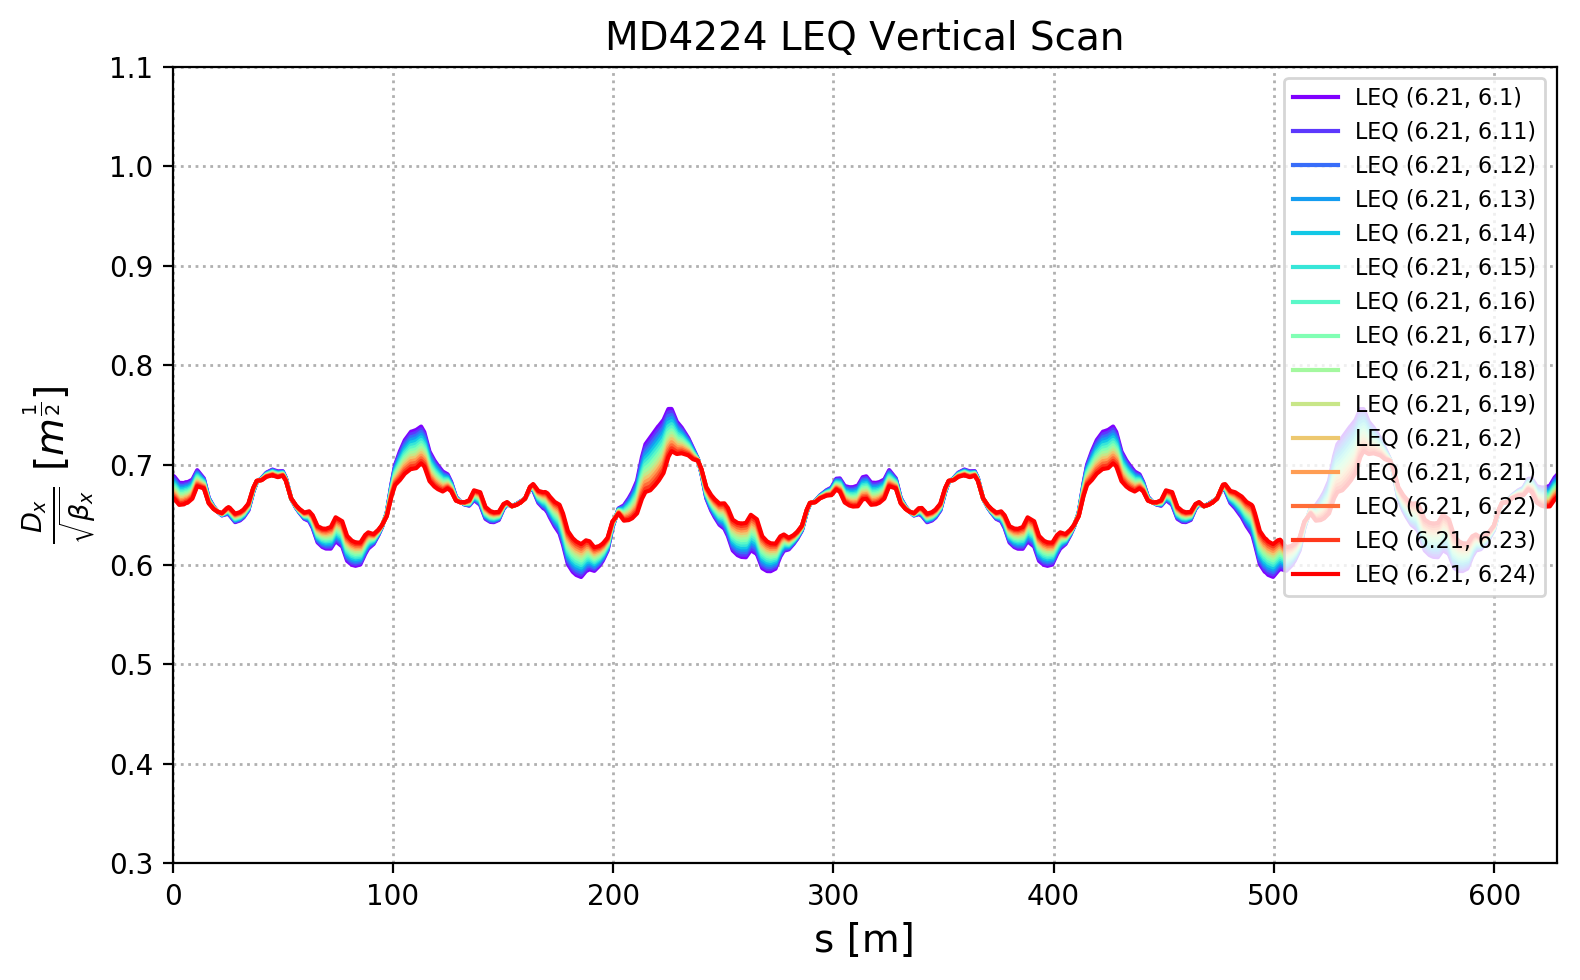

In [100]:
parameter1 = 'DISP1'
parameter2 = 'BETX'
case_label = 'LEQ Vertical Scan'

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

tit = main_label+ ' ' + case_label
ax1.set_title(tit);

ax1.set_xlabel('s [m]');
ax1.set_ylabel(r'$\frac{D_x}{\sqrt{\beta_x}}$ [$m^{\frac{1}{2}}$]');

colors = cm.rainbow(np.linspace(0, 1, len(LEQ_V_List)))
c_it = int(0)
for d in LEQ_V_List:
    lab_ =  'LEQ (' + str(6+round_sig(d['HEADER_Q1'][0],2)) + ', ' + str(6+round_sig(d['HEADER_Q2'][0],2)) + ')'
    x = np.array(d['S'])
    y = beta * np.array(d[parameter1])/np.sqrt(np.array(d[parameter2]))
    ax1.plot(x,y, label=lab_, color=colors[c_it]);
    c_it = c_it + 1;

ax1.legend(loc=1)
ax1.grid(lw=1, ls=':');
ax1.set_ylim(0.3, 1.1)
ax1.set_xlim(0., (200.*np.pi))

savename = V_save_folder + '/'+ main_label + '_' + parameter1 + '_normalised.png'
plt.tight_layout()
plt.savefig(savename, dpi = 200);

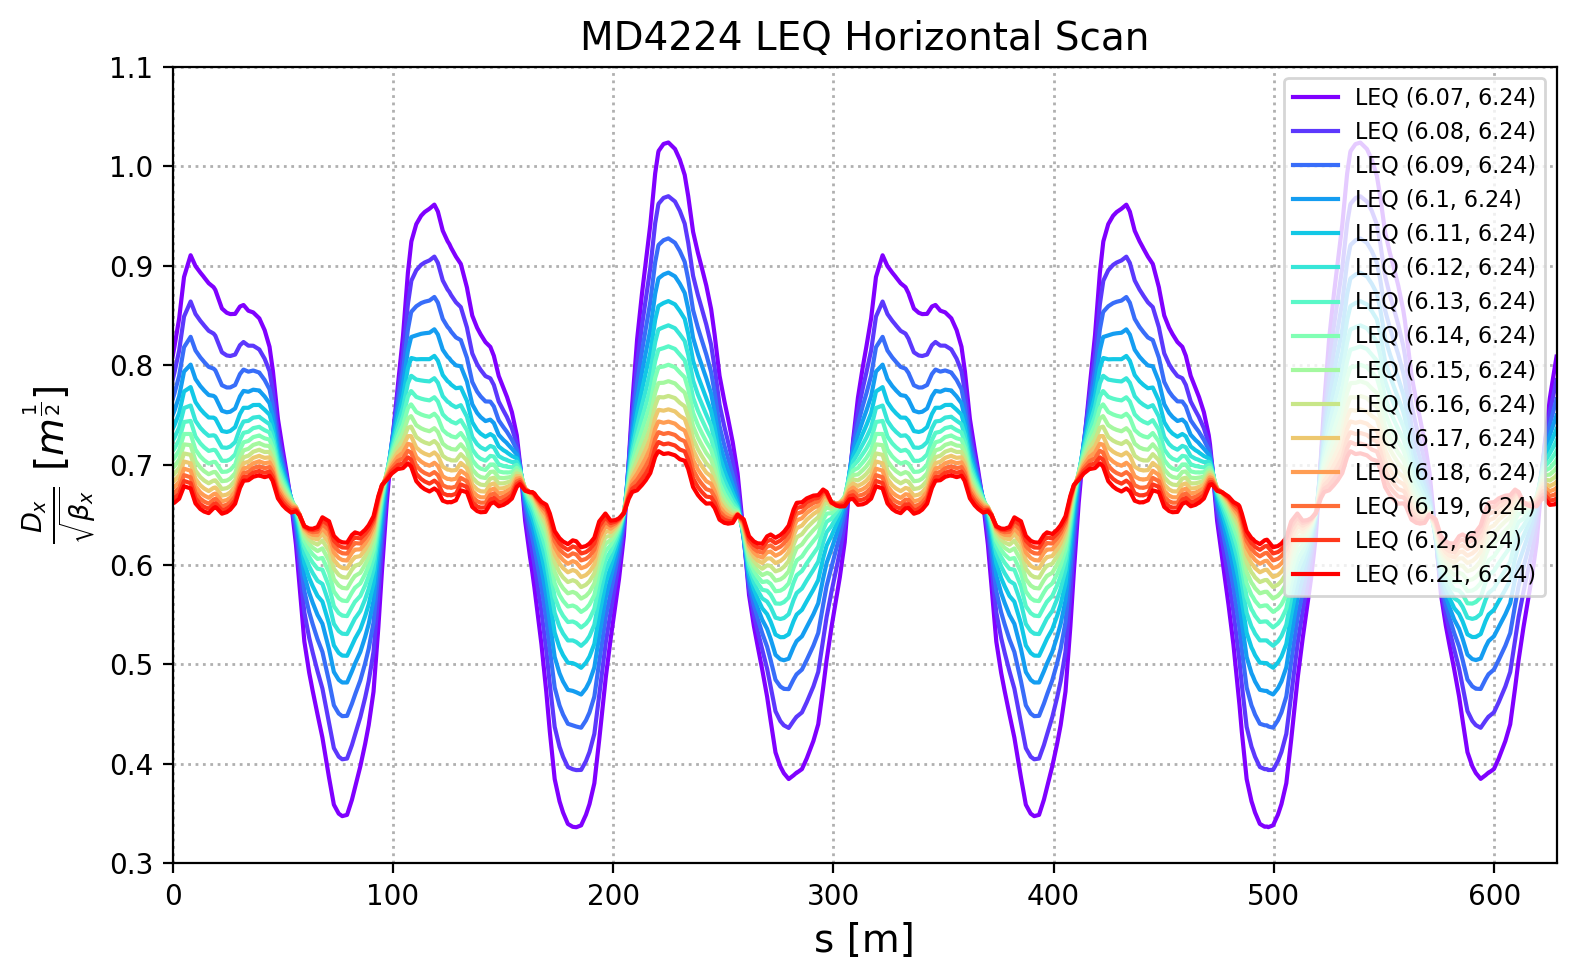

In [101]:
parameter1 = 'DISP1'
parameter2 = 'BETX'
case_label = 'LEQ Horizontal Scan'

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

tit = main_label+ ' ' + case_label
ax1.set_title(tit);

ax1.set_xlabel('s [m]');
ax1.set_ylabel(r'$\frac{D_x}{\sqrt{\beta_x}}$ [$m^{\frac{1}{2}}$]');

colors = cm.rainbow(np.linspace(0, 1, len(LEQ_H_List)))
c_it = int(0)
for d in LEQ_H_List:
    lab_ =  'LEQ (' + str(6+round_sig(d['HEADER_Q1'][0],2)) + ', ' + str(6+round_sig(d['HEADER_Q2'][0],2)) + ')'
    x = np.array(d['S'])
    y = beta * np.array(d[parameter1])/np.sqrt(np.array(d[parameter2]))
    ax1.plot(x,y, label=lab_, color=colors[c_it]);
    c_it = c_it + 1;

ax1.legend(loc=1)
ax1.grid(lw=1, ls=':');
ax1.set_ylim(0.3, 1.1)
ax1.set_xlim(0., (200.*np.pi))

savename = Hsave_folder + '/'+ main_label + '_' + parameter1 + '_normalised.png'
plt.tight_layout()
plt.savefig(savename, dpi = 200);

# Measurements

From Matthew's talk:

https://indico.cern.ch/event/828559/contributions/3528423/attachments/1938485/3214110/MFraser_SpaceChargeWS_PS_blowup.pdf

measurements show that the turn-by-turn dispersion at the SEM grid is beating around a different closed dispersion than that expected from the model. This is summarised in slide 9:

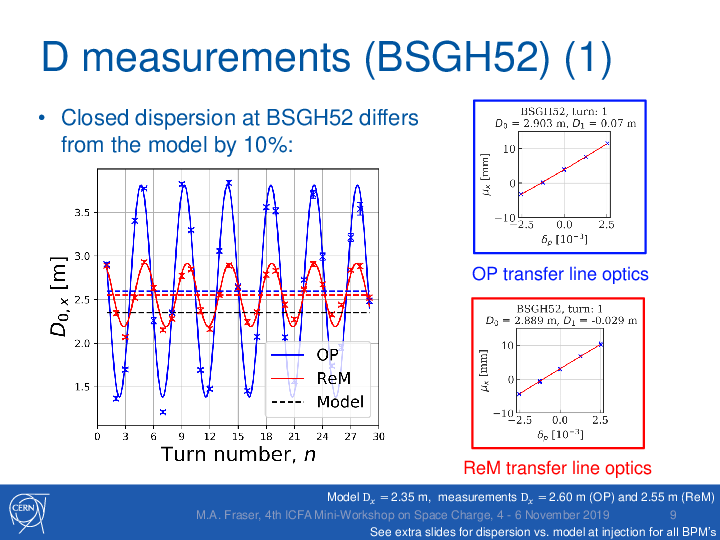

In [102]:
img = WImage(filename='MFraser_SpaceChargeWS_PS_blowup.pdf[8]')
img

On the left hand plot the dashed straight lines (red, blue) represent the value around which the dispersion beats, this is taken as the measured closed dispersion value. The black dashed straight line is the value expected from the model (via PTC Twiss) for illustration of the difference between expectation and measurement.

### Closed Dispersion @ SEM Grid:
- Model (value from PTC Twiss)
    - D_x_0 = 2.35 m
- Operational (measured)
    - D_x_0 = 2.60 m
- ReMatched (measured)
    - D_x_0 = 2.55 m

Our goal is to apply the same mismatch at a different position.

By normalising: $$ \bar{D}_x = \frac{D_x}{\sqrt{\beta_x}} $$

we can fit the turn-by-turn beating to obtain the mismatch amplitude $M_D$:
$$ \bar{D}_x(n) = \bar{D}_{x_0}(n) + M_D cos(\theta + 2\pi(n-1)q_x)$$

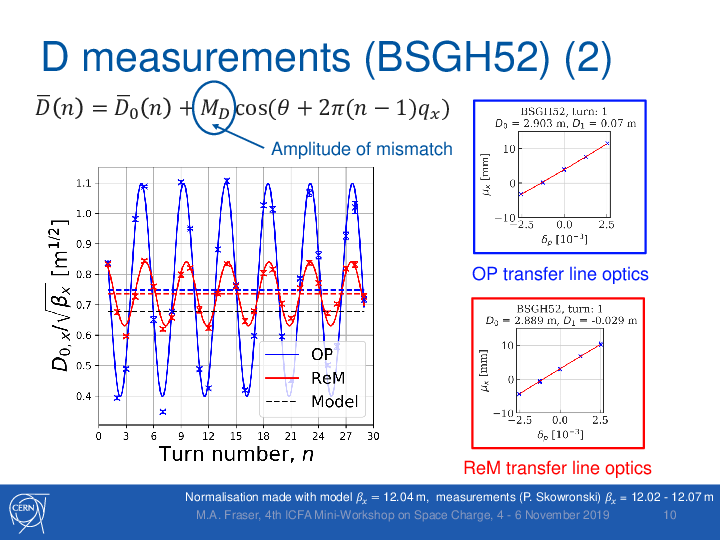

In [103]:
img = WImage(filename='MFraser_SpaceChargeWS_PS_blowup.pdf[9]')
img

We may compare the dashed black line with our PTC Twiss normalised starting dispersion.

$\frac{D_{x_0}}{\sqrt{\beta_x}} = $

In [104]:
print round_sig(d_ps_transfer['DISP1'][0]/np.sqrt(d_ps_transfer['BETX'][0]),4), 'm^{1/2}'
print 'From Talk:', round_sig(2.35/np.sqrt(12.04)), 'm^{1/2}'

NameError: name 'd_ps_transfer' is not defined

Note there is some small difference as the beta values are different (one measured, one from PTC twiss).

Using 
$$ \bar{D}_x(n) = \bar{D}_{x_0}(n) + M_D cos(\theta + 2\pi(n-1)q_x)$$

With $D_{x_0}$ = 2.35 (use Matt's values from slide 9) we may use fitted values from dispersion vector simulations (found in PS Transfer repository) to check our values with the measurement data shown on the slides.

- Operational:

In [105]:
#beta_x = d_ps_transfer['BETX'][0]
beta_x = 12.04 #Matt's value (measured)
d_x0 = 2.60
M_D = 0.350
theta = 1.36

print 'D_x_0_normalised = ', round_sig(d_x0/np.sqrt(beta_x)), ' m^{1/2}'
print 'D_x_0 = ', round_sig(d_x0), 'm'

D_bar_x_1 = (d_x0/np.sqrt(beta_x)) + M_D*np.cos(theta)
print '\nAfter mismatch D_x_0_normalised = ',round_sig(D_bar_x_1), ' m^{1/2}'
print 'After mismatch D_x_0 = ', round_sig(D_bar_x_1*np.sqrt(beta_x)), 'm'
print 'From slide D_x_0_normalised = ', round_sig(2.903/np.sqrt(beta_x)), ' m^{1/2}'
print 'From slide D_x_0 = ', round_sig(2.903), ' m'

# check turn 5
turn = 5
q_x = 0.2182

D_bar_x_1 = (d_x0/np.sqrt(beta_x)) + M_D*np.cos(theta + (2*np.pi*(turn-1)*q_x))
print '\n5 turns after mismatch D_x_5_normalised = ',round_sig(D_bar_x_1), ' m^{1/2}'
print '5 turns after mismatch D_x_5 = ',round_sig(D_bar_x_1*np.sqrt(beta_x)), ' m'
print 'From slide ~ ', round_sig(3.8/np.sqrt(12.04)), ' m^{1/2}'
print 'From slide ~ ', round_sig(3.8), ' m'

# check turn 5
turn = 12
q_x = 0.2182

D_bar_x_1 = (d_x0/np.sqrt(beta_x)) + M_D*np.cos(theta + (2*np.pi*(turn-1)*q_x))
print '\n12 turns after mismatch D_x_5_normalised = ',round_sig(D_bar_x_1), ' m^{1/2}'
print '12 turns after mismatch D_x_5 = ',round_sig(D_bar_x_1*np.sqrt(beta_x)), ' m'
print 'From slide ~ ', round_sig(1.5/np.sqrt(12.04)), ' m^{1/2}'
print 'From slide ~ ', round_sig(1.5), ' m'

D_x_0_normalised =  0.749  m^{1/2}
D_x_0 =  2.6 m

After mismatch D_x_0_normalised =  0.823  m^{1/2}
After mismatch D_x_0 =  2.85 m
From slide D_x_0_normalised =  0.837  m^{1/2}
From slide D_x_0 =  2.9  m

5 turns after mismatch D_x_5_normalised =  1.05  m^{1/2}
5 turns after mismatch D_x_5 =  3.63  m
From slide ~  1.1  m^{1/2}
From slide ~  3.8  m

12 turns after mismatch D_x_5_normalised =  0.489  m^{1/2}
12 turns after mismatch D_x_5 =  1.7  m
From slide ~  0.432  m^{1/2}
From slide ~  1.5  m


- ReMatched

In [106]:
#beta_x = d_ps_transfer['BETX'][0]
beta_x = 12.04 #Matt's value (measured)
d_x0 = 2.55
M_D = 0.107
theta = 0.5285

print 'D_x_0_normalised = ', round_sig(d_x0/np.sqrt(beta_x)), ' m^{1/2}'
print 'D_x_0 = ', round_sig(d_x0), 'm'

D_bar_x_1 = (d_x0/np.sqrt(beta_x)) + M_D*np.cos(theta)
print '\nAfter mismatch D_x_0_normalised = ',round_sig(D_bar_x_1), ' m^{1/2}'
print 'After mismatch D_x_0 = ', round_sig(D_bar_x_1*np.sqrt(beta_x)), 'm'
print 'From slide D_x_0_normalised = ', round_sig(2.889/np.sqrt(beta_x)), ' m^{1/2}'
print 'From slide D_x_0 = ', round_sig(2.889), ' m'

# check turn 5
turn = 5
q_x = 0.2183

D_bar_x_1 = (d_x0/np.sqrt(beta_x)) + M_D*np.cos(theta + (2*np.pi*(turn-1)*q_x))
print '\n5 turns after mismatch D_x_5_normalised = ',round_sig(D_bar_x_1), ' m^{1/2}'
print '5 turns after mismatch D_x_5 = ',round_sig(D_bar_x_1*np.sqrt(beta_x)), ' m'
print 'From slide ~ ', round_sig(2.9/np.sqrt(12.04)), ' m^{1/2}'
print 'From slide ~ ', round_sig(2.9), ' m'

# check turn 12
turn = 12
q_x = 0.2182

D_bar_x_1 = (d_x0/np.sqrt(beta_x)) + M_D*np.cos(theta + (2*np.pi*(turn-1)*q_x))
print '\n12 turns after mismatch D_x_5_normalised = ',round_sig(D_bar_x_1), ' m^{1/2}'
print '12 turns after mismatch D_x_5 = ',round_sig(D_bar_x_1*np.sqrt(beta_x)), ' m'
print 'From slide ~ ', round_sig(2.2/np.sqrt(12.04)), ' m^{1/2}'
print 'From slide ~ ', round_sig(2.2), ' m'

D_x_0_normalised =  0.735  m^{1/2}
D_x_0 =  2.55 m

After mismatch D_x_0_normalised =  0.827  m^{1/2}
After mismatch D_x_0 =  2.87 m
From slide D_x_0_normalised =  0.833  m^{1/2}
From slide D_x_0 =  2.89  m

5 turns after mismatch D_x_5_normalised =  0.838  m^{1/2}
5 turns after mismatch D_x_5 =  2.91  m
From slide ~  0.836  m^{1/2}
From slide ~  2.9  m

12 turns after mismatch D_x_5_normalised =  0.628  m^{1/2}
12 turns after mismatch D_x_5 =  2.18  m
From slide ~  0.634  m^{1/2}
From slide ~  2.2  m


### Using our dispersion vector simulations to find theta (using Matt's provided $D_{x_0}$ $D_{x_0}^{\prime}$ values to match the dispersion mismatch amplitude), we can fit the measurement reasonably well

We see from Matt's measurements that the dispersion mismatch amplitude is roughly constant over the whole machine.

In [ ]:
img = WImage(filename='MFraser_SpaceChargeWS_PS_blowup.pdf[11]')
img

In simulations, Matt adjusted the initial conditions in simulations such that the relative turn-by-turn dispersion beating was reproduced. The measured D_x values were shifted, D_px was fitted until the relative turn-by-turn beating in simulations matched measurements.

In [ ]:
img = WImage(filename='MFraser_SpaceChargeWS_PS_blowup.pdf[13]')
img

### Assuming:
- closed dispersion at SEM is PTC twiss value of $D_{x_{SEM}}$ = 2.35 m
- mismatch amplitude $M_D$ = 0.350
- phase of mismatch $\theta$ = 1.36 (from dispersion vector matching study)
- $\beta_{x_{SEM}}$ = 12.04 m (Matt's measured value)
- $\sqrt{\beta_{x_{SEM}}}$ = 3.47

## To obtain shifted dispersion starting value

###  using mismatch function

- Normalised dispersion 

$$\bar{D_x} = \frac{D_x}{\sqrt{\beta_x}} = \frac{2.35}{3.47} = 0.677~m^{\frac{1}{2}}$$

- Take cosine term as maximum (=1)

$$ \bar{D_x}_{SEM_{mismatched}} = D_{x_{SEM}} + M_D cos (\theta) = 0.677 + 0.35 cos(1.36) = 0.677 + 0.073 = 0.75~m^{\frac{1}{2}}$$

$$ D_{x_{wire-scanner_{mismatched}}} = 0.75 \sqrt{12.04} = 2.6025~m $$

- Normalised dispersion delta

$$\Delta \bar{D_x}_{SEM Grid} = 0.75-0.677 = 0.073~m^{\frac{1}{2}}$$

- Absolute dispersion delta 

$$ \Delta D_{x_{SEM Grid}} = 2.6025 - 2.35 = 0.2525~m $$
$$ \Delta D_{x_{SEM Grid}} = 2.633 - 2.35 = 0.283~m $$

## From data (first turn data point)
$$\Delta \bar{D_x}_{SEM Grid} = 0.823-0.749 = 0.074~m^{\frac{1}{2}}$$


In [ ]:
img = WImage(filename='MFraser_SpaceChargeWS_PS_blowup.pdf[14]')
img

### Model values from PTC Twiss
- Lattice (MAD-X v 5.02.00 PTC Twiss D_x_0 = 2.576404793*0.9158 = 2.3536)
    - $D_{x_0}$ = 2.35 m
    - $D_{x_0}^{\prime}$ = -0.007439

### Values from Matt's matching simulations of mismatch amplitude beating
- Operational
    - $D_{x_0}$ = 2.633 m
    - $D_{x_0}^{\prime}$ = -0.1104 (typo in Matt's slide)
    - $M_D$ = 0.35
- ReMatched
    - $D_{x_0}$ = 2.683 m
    - $D_{x_0}^{\prime}$ = -0.022
    - $M_D$ = 0.107

# Apply mismatch to new location 

### Assuming:
- closed dispersion at wire-scanner is PTC twiss value of $D_{x_{wire-scanner}}$ = 3.123 m
- mismatch amplitude $M_D$ = 0.350
- phase of mismatch $\theta$ = 1.36
- $\beta_{x_{wire-scanner}}$ = 22.45

## Working method

- Normalised dispersion 

$$\bar{D_x} = \frac{D_x}{\sqrt{\beta_x}} = \frac{3.123}{4.737} = 0.659~m^{\frac{1}{2}}$$

- Take cosine term as maximum (=1)
$$ \bar{D_x}_{wire-scanner_{mismatched}} = D_{x_{wire-scanner}} + M_D cos (\theta) = 0.659 + 0.35 = 1.009~m^{\frac{1}{2}}$$

$$ D_{x_{wire-scanner_{mismatched}}} = 1.009 \sqrt{22.435} = 4.78~m$$

- Normalised dispersion delta

$$\Delta \bar{D_x}_{wire-scanner} = 1.009-0.659 = 0.35~m^{\frac{1}{2}}$$

$$\Delta \bar{D_x}_{SEM Grid} = 0.823-0.749 = 0.074~m^{\frac{1}{2}}$$

- Absolute dispersion delta 
$$ \Delta D_{x_{wire-scanner}} = 4.78 - 3.123 = 1.65~m $$

$$ \Delta D_{x_{SEM Grid}} = 2.633 - 2.35 = 0.283~m $$

# MD4224 Light Horizontal

In [123]:
Delta_D, D_m = find_dispersion_mismatch(LEQ_H_07)

(Qx, Qy) = ( 0.07 , 0.24 )
	D_0 =  3.9349
	D_0_norm =  0.8832
	D_mismatched_norm =  1.2332
	D_mismatched =  5.4942
	Delta_D_mismatched =  1.5593


In [129]:
for d in LEQ_H_List:
    Delta_D, D_m = find_dispersion_mismatch(d, Horizontal=True, M_D=0.35, beta = 0.9156, verbose=True)

(Qx, Qy) = ( 0.07 , 0.24 )
	D_0 =  3.6028
	D_0_norm =  0.80865
	D_mismatched_norm =  1.1587
	D_mismatched =  5.1621
	Delta_D_mismatched =  1.5593
(Qx, Qy) = ( 0.08 , 0.24 )
	D_0 =  3.5404
	D_0_norm =  0.78504
	D_mismatched_norm =  1.135
	D_mismatched =  5.1189
	Delta_D_mismatched =  1.5785
(Qx, Qy) = ( 0.09 , 0.24 )
	D_0 =  3.4857
	D_0_norm =  0.76573
	D_mismatched_norm =  1.1157
	D_mismatched =  5.0789
	Delta_D_mismatched =  1.5932
(Qx, Qy) = ( 0.1 , 0.24 )
	D_0 =  3.4375
	D_0_norm =  0.74963
	D_mismatched_norm =  1.0996
	D_mismatched =  5.0424
	Delta_D_mismatched =  1.6049
(Qx, Qy) = ( 0.11 , 0.24 )
	D_0 =  3.3947
	D_0_norm =  0.73599
	D_mismatched_norm =  1.086
	D_mismatched =  5.009
	Delta_D_mismatched =  1.6143
(Qx, Qy) = ( 0.12 , 0.24 )
	D_0 =  3.3565
	D_0_norm =  0.72426
	D_mismatched_norm =  1.0743
	D_mismatched =  4.9785
	Delta_D_mismatched =  1.622
(Qx, Qy) = ( 0.13 , 0.24 )
	D_0 =  3.322
	D_0_norm =  0.71402
	D_mismatched_norm =  1.064
	D_mismatched =  4.9503
	Delta_D_mismat

In [130]:
for d in LEQ_V_List:
    Delta_D, D_m = find_dispersion_mismatch(d, Horizontal=False, M_D=0.35, beta = 0.9156, verbose=True)

(Qx, Qy) = ( 0.21 , 0.1 )
	D_0 =  2.419
	D_0_norm =  0.49903
	D_mismatched_norm =  0.84903
	D_mismatched =  4.1155
	Delta_D_mismatched =  1.6966
(Qx, Qy) = ( 0.21 , 0.11 )
	D_0 =  2.4144
	D_0_norm =  0.50139
	D_mismatched_norm =  0.85139
	D_mismatched =  4.0999
	Delta_D_mismatched =  1.6854
(Qx, Qy) = ( 0.21 , 0.12 )
	D_0 =  2.4099
	D_0_norm =  0.50308
	D_mismatched_norm =  0.85308
	D_mismatched =  4.0866
	Delta_D_mismatched =  1.6766
(Qx, Qy) = ( 0.21 , 0.13 )
	D_0 =  2.4054
	D_0_norm =  0.50424
	D_mismatched_norm =  0.85424
	D_mismatched =  4.075
	Delta_D_mismatched =  1.6696
(Qx, Qy) = ( 0.21 , 0.14 )
	D_0 =  2.4009
	D_0_norm =  0.505
	D_mismatched_norm =  0.855
	D_mismatched =  4.0649
	Delta_D_mismatched =  1.664
(Qx, Qy) = ( 0.21 , 0.15 )
	D_0 =  2.3964
	D_0_norm =  0.50545
	D_mismatched_norm =  0.85545
	D_mismatched =  4.0559
	Delta_D_mismatched =  1.6594
(Qx, Qy) = ( 0.21 , 0.16 )
	D_0 =  2.392
	D_0_norm =  0.50564
	D_mismatched_norm =  0.85564
	D_mismatched =  4.0477
	Delta_D_m

In [ ]:
### Assuming:
- closed dispersion at wire-scanner is PTC twiss value of $D_{x_{wire-scanner}}$ = 3.123 m
- mismatch amplitude $M_D$ = 0.350
- phase of mismatch $\theta$ = 1.36
- $\beta_{x_{H wire-scanner}}$ = 22.45

In [109]:
return_initial_Parameter(LEQ_H_07, 'BETX')

19.84948902

In [ ]:
## Working method

- Normalised dispersion 

$$\bar{D_x} = \frac{D_x}{\sqrt{\beta_x}} = \frac{3.123}{4.737} = 0.659~m^{\frac{1}{2}}$$

- Take cosine term as maximum (=1)
$$ \bar{D_x}_{wire-scanner_{mismatched}} = D_{x_{wire-scanner}} + M_D cos (\theta) = 0.659 + 0.35 = 1.009~m^{\frac{1}{2}}$$

$$ D_{x_{wire-scanner_{mismatched}}} = 1.009 \sqrt{22.435} = 4.78~m$$

- Normalised dispersion delta

$$\Delta \bar{D_x}_{wire-scanner} = 1.009-0.659 = 0.35~m^{\frac{1}{2}}$$

$$\Delta \bar{D_x}_{SEM Grid} = 0.823-0.749 = 0.074~m^{\frac{1}{2}}$$

- Absolute dispersion delta 
$$ \Delta D_{x_{wire-scanner}} = 4.78 - 3.123 = 1.65~m $$

$$ \Delta D_{x_{SEM Grid}} = 2.633 - 2.35 = 0.283~m $$